In [1]:
import numpy as np   # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import warnings
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor

In this kernal, I would like to share my first Kaggle Exercise on establishing a few working models. The key steps include:

1. Data EDA and develop intuitions, by using seaborn graphing library

2. Fill missing values and perform additional feature engineering (e.g. one hot encoding)

3. Build a few working models: Xgboost, Lightboost, Ridge Regression

4. Build a Stacked Ensemble model by leveraging the prior models

While develping this kernal, I have learned a lot from the following Authors and their works.

[Stacked Regressions : Top 4% on LeaderBoard](https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard) 
I draw the idea of building the stacked model from this kernal, but I actually used the the sklearn library rather than method from here

[Comprehensive data exploration with Python](https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python/notebook)
From this post, I learned various data EDA techniques

[Regularized Linear Models](https://www.kaggle.com/code/apapiu/regularized-linear-models/notebook)
Good material to review how to build regularized linear models

[How I made top 0.3% on a Kaggle competition](https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition)
This post is pretty interesting as well


In this Kernal, for each model I built, I will further break down the training data into "df_seg_train" and "df_seg_test". What I am trying to do is to objectively test my model before submitting the final predictions. This should give me a good sense as what kind of accuracy I should expect from the submission


In [2]:
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
data = '/Volumes/GoogleDrive/My Drive/data science/03_house_price_advanced_regression/data'
df_train = pd.read_csv(os.path.join(data, 'train.csv'))
df_test = pd.read_csv(os.path.join(data, 'test.csv'))
df_data = df_train.append(df_test, ignore_index=True)

In [4]:
# identify numeric or categorical variables
df_data['MSSubClass'] = df_data['MSSubClass'].astype(str)
num_cols = []
cat_cols = []
for col in df_data.columns:
    if df_data[col].dtypes in ['int64', 'float64']:
        if (col !='Id') & (col !='SalePrice'):
            num_cols.append(col)
    else:
        cat_cols.append(col)

In [5]:
df_data['log_SalePrice'] = np.log(df_data['SalePrice'])

1. Data EDA, develop data intuitions

Text(0.5, 1.0, 'SalePrice Distribution')

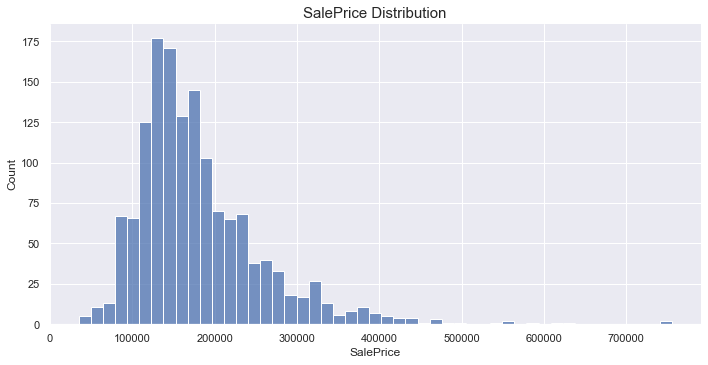

In [7]:
fig = sns.displot(data=df_data, x = 'SalePrice', kind='hist', height=5, aspect = 2)
plt.title(f'SalePrice Distribution', fontsize=15)
# not normal distribution, does it matter? 

/Users/ryansun/opt/anaconda3/envs/analytics37/lib/python3.7/site-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


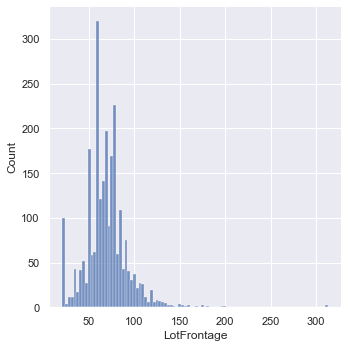

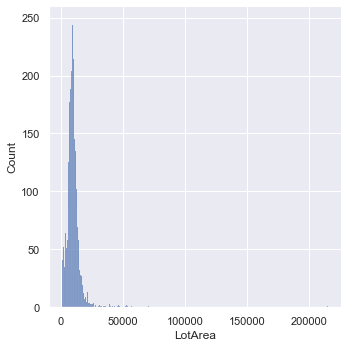

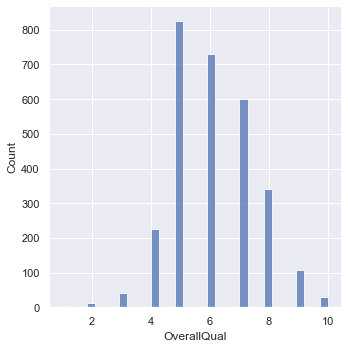

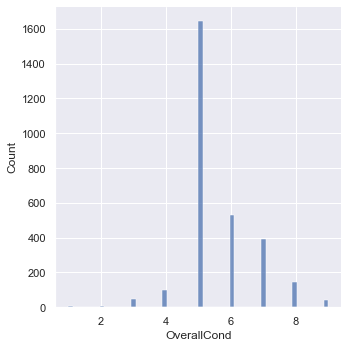

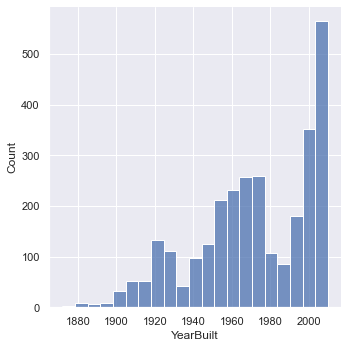

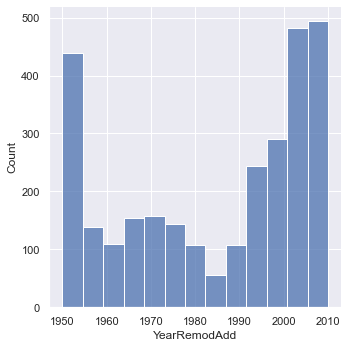

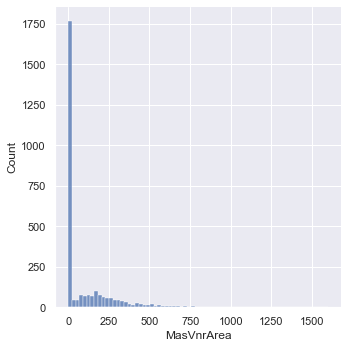

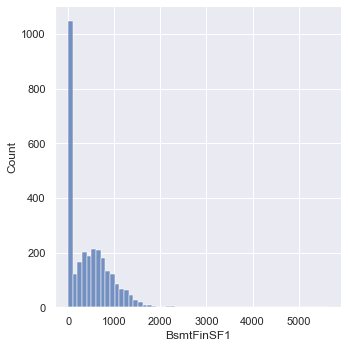

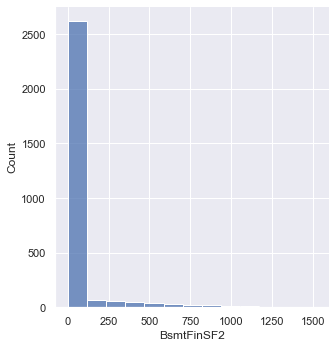

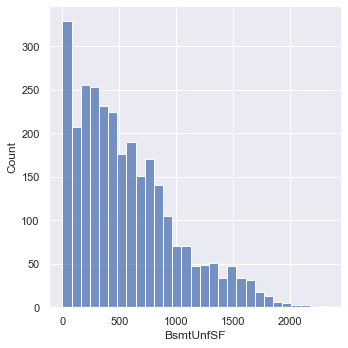

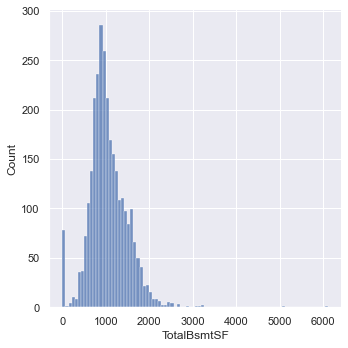

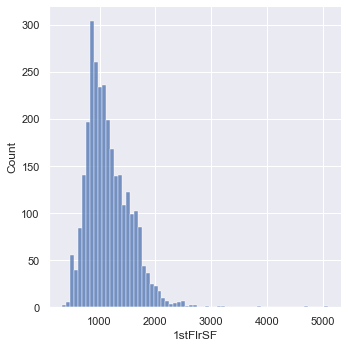

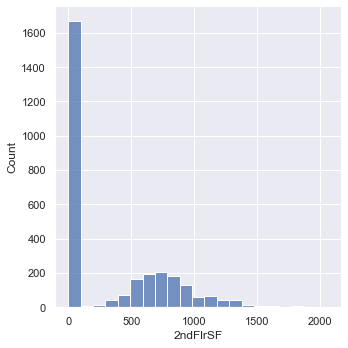

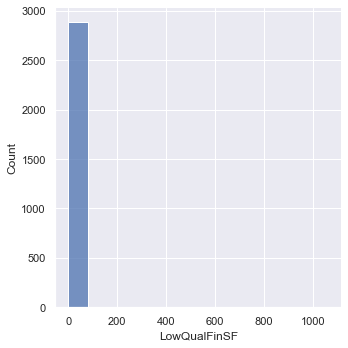

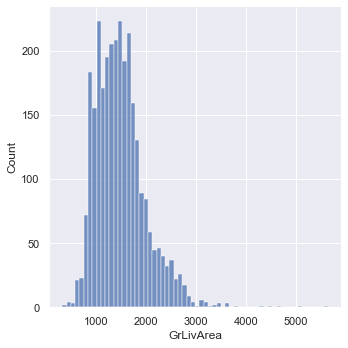

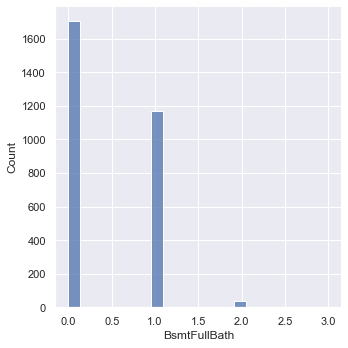

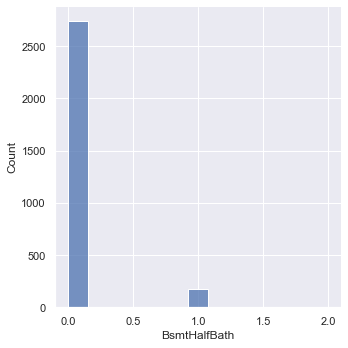

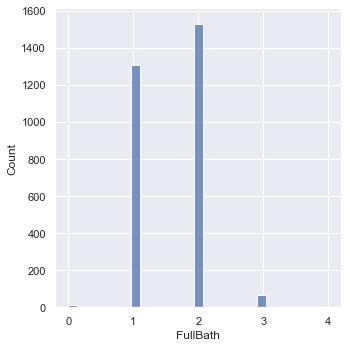

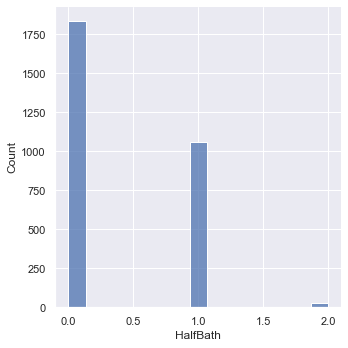

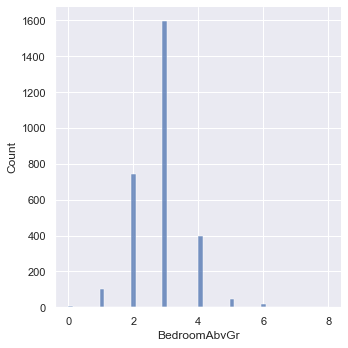

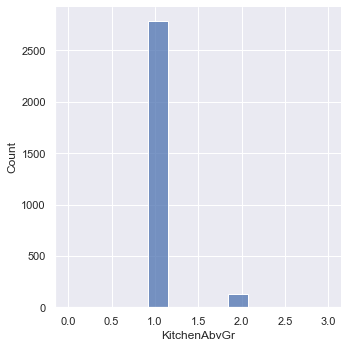

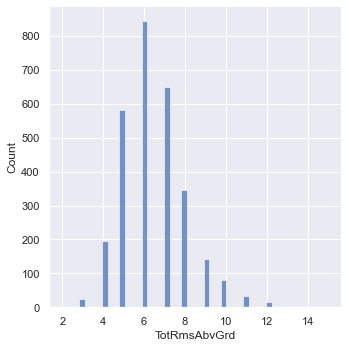

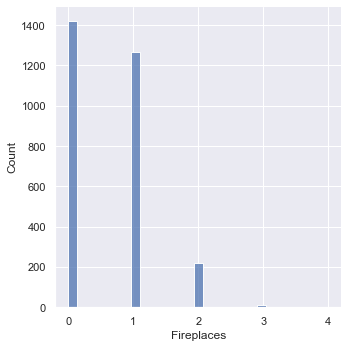

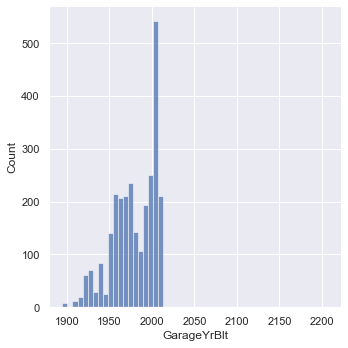

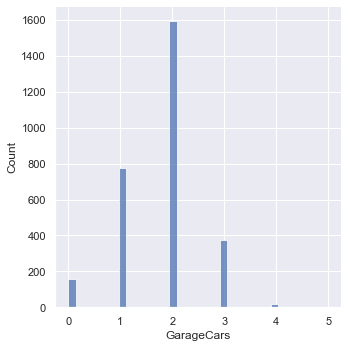

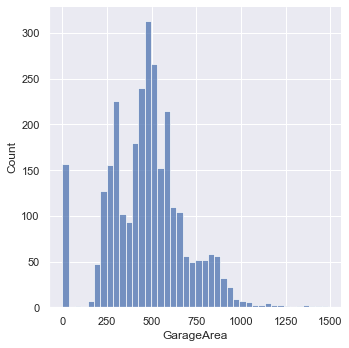

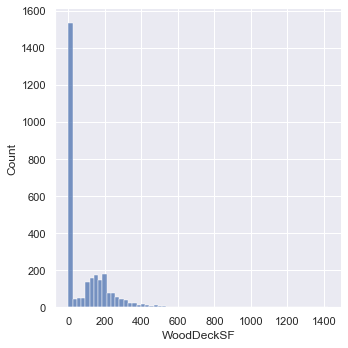

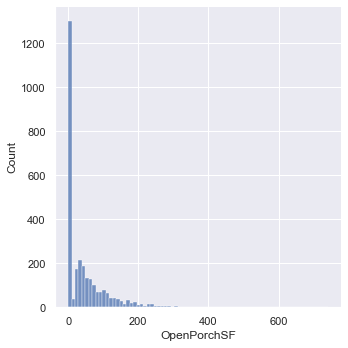

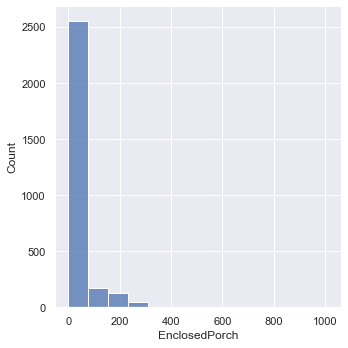

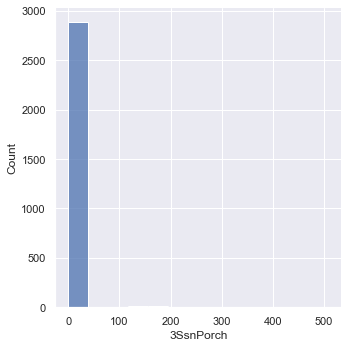

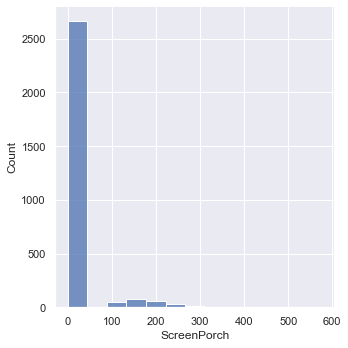

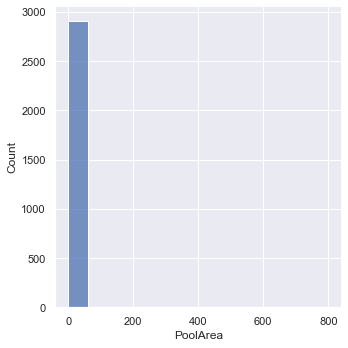

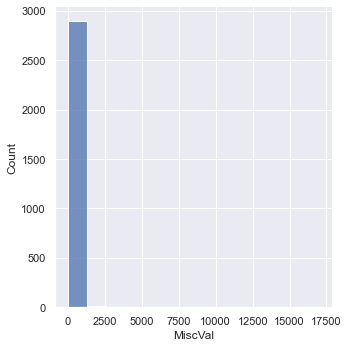

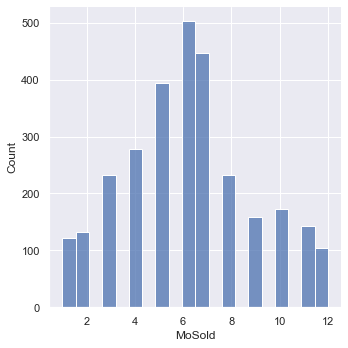

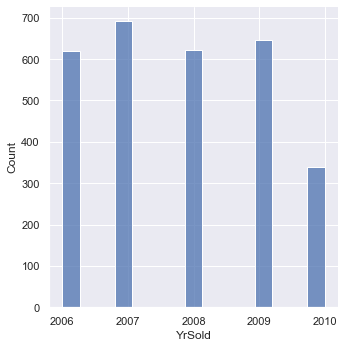

In [8]:
for col in num_cols:
    sns.displot(data=df_data, x = col, kind='hist')

/Users/ryansun/opt/anaconda3/envs/analytics37/lib/python3.7/site-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


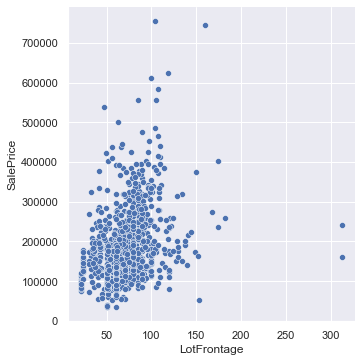

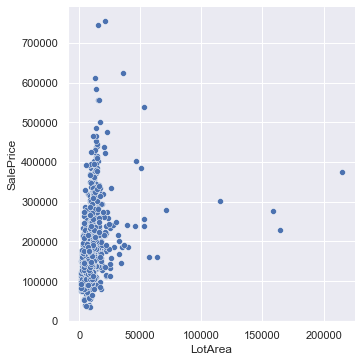

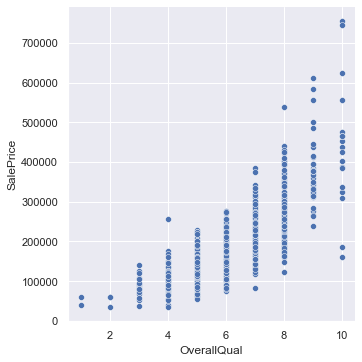

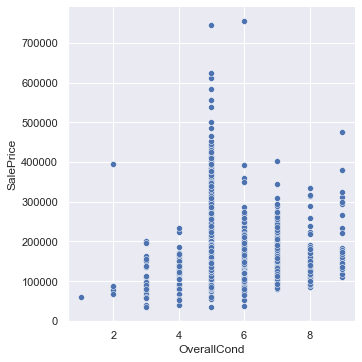

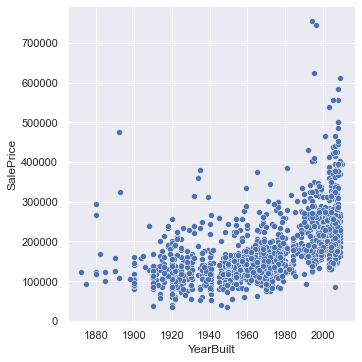

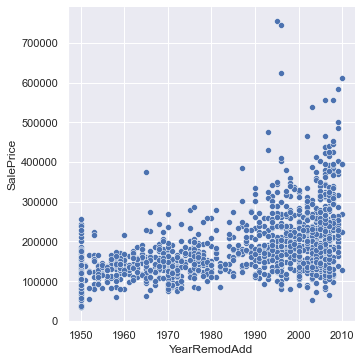

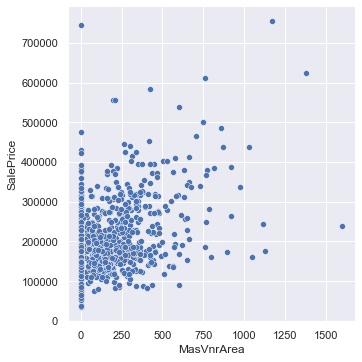

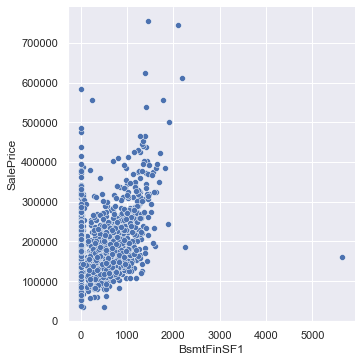

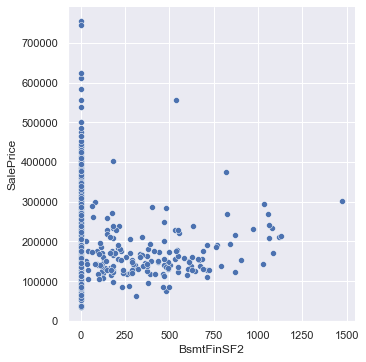

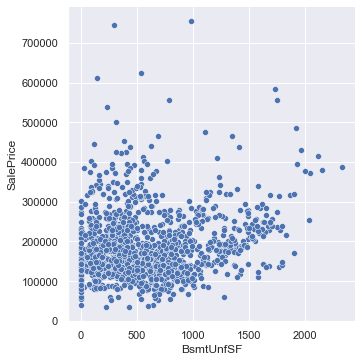

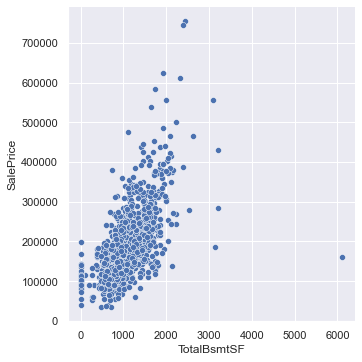

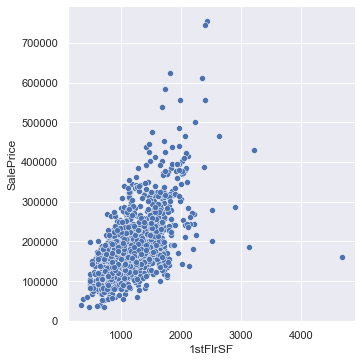

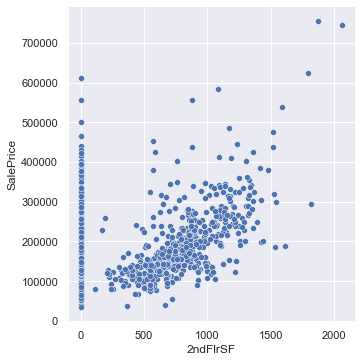

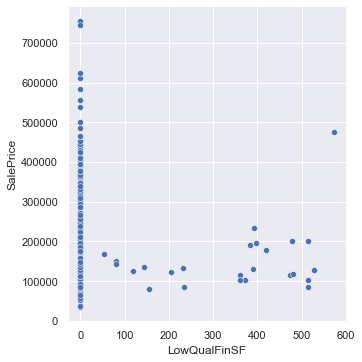

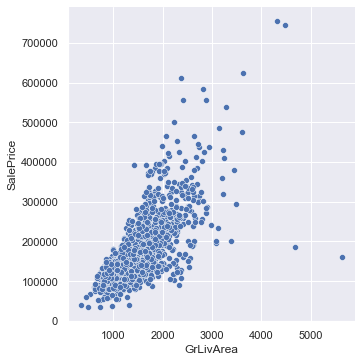

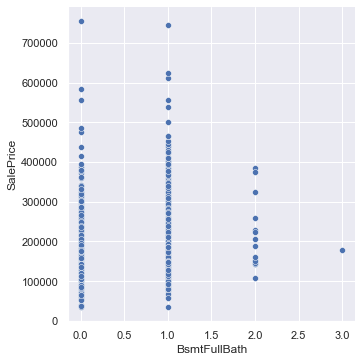

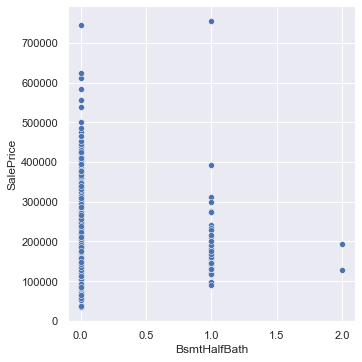

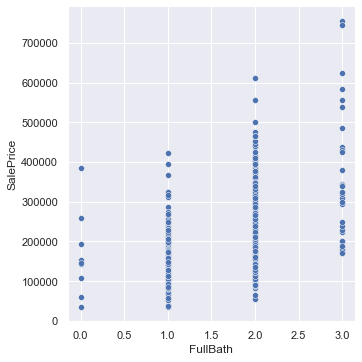

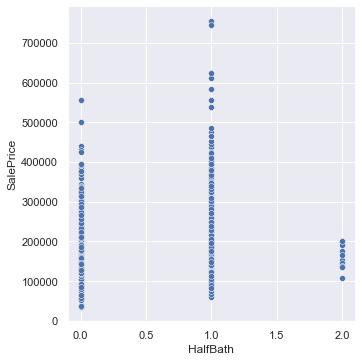

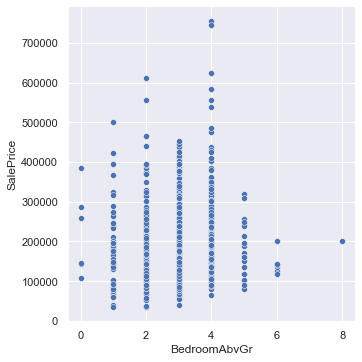

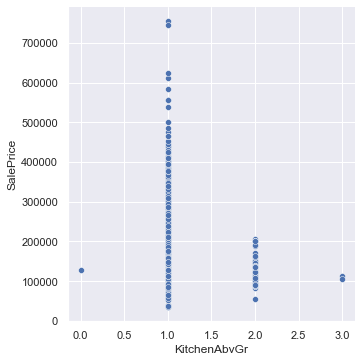

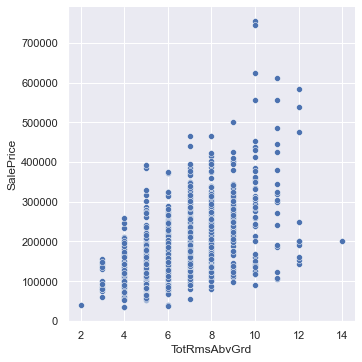

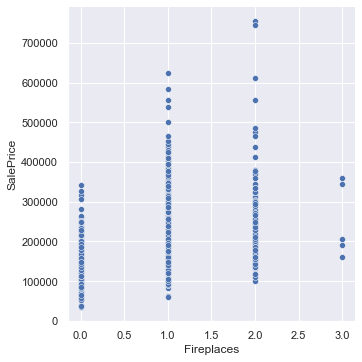

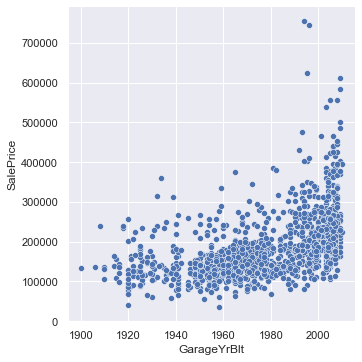

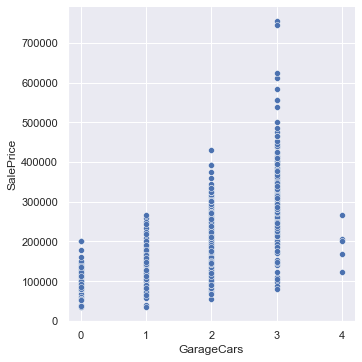

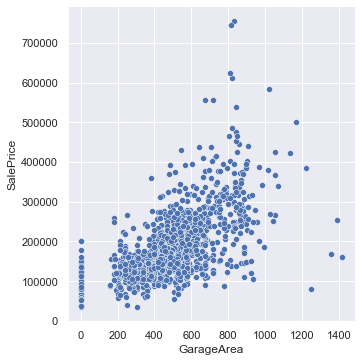

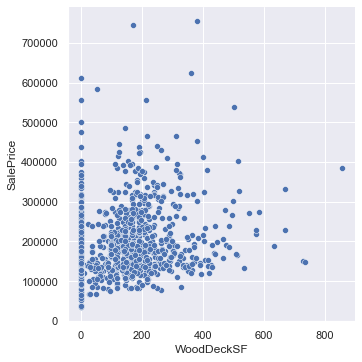

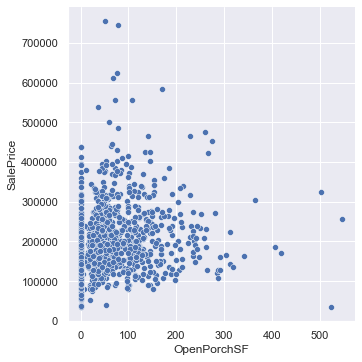

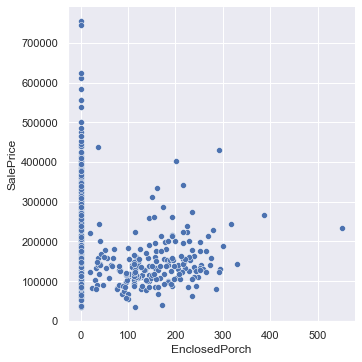

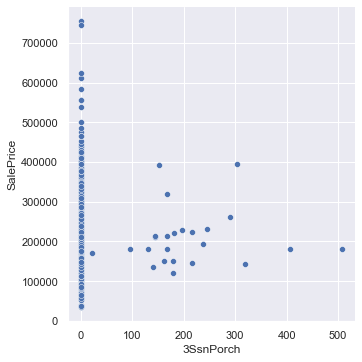

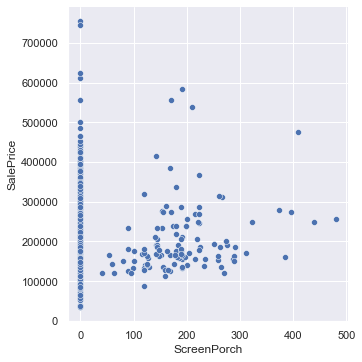

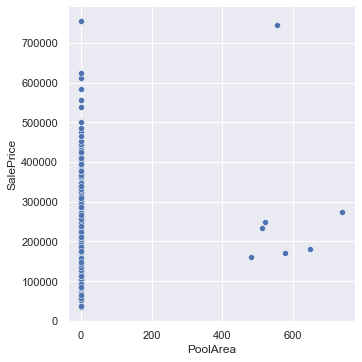

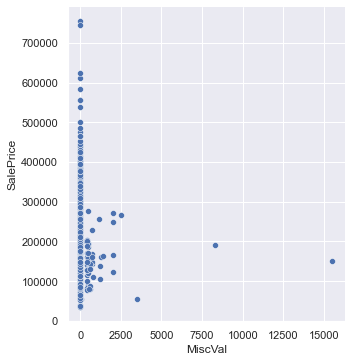

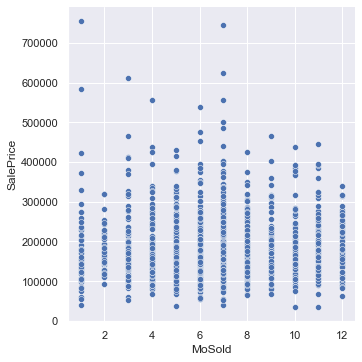

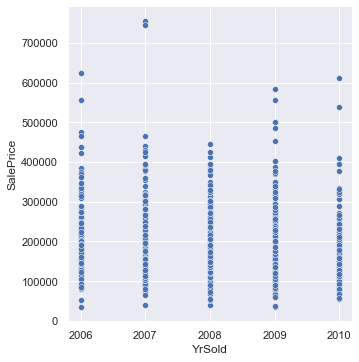

In [9]:
# exam the correlation with Sale Price
for col in num_cols:
    sns.relplot(data=df_data, x=col, y="SalePrice")

/Users/ryansun/opt/anaconda3/envs/analytics37/lib/python3.7/site-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


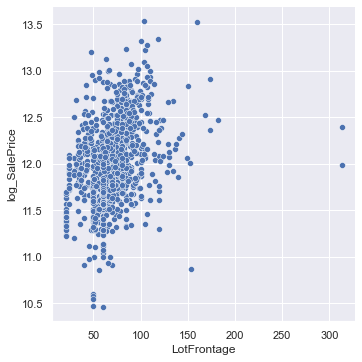

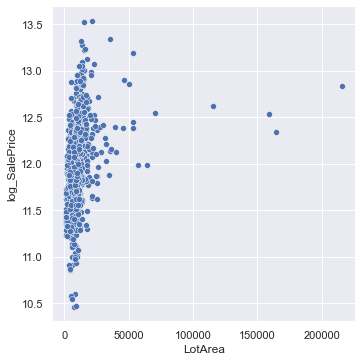

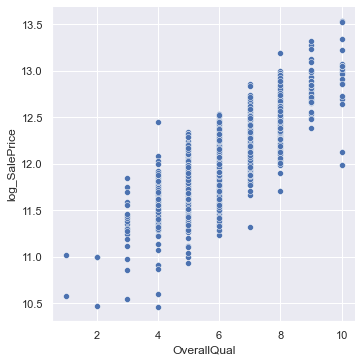

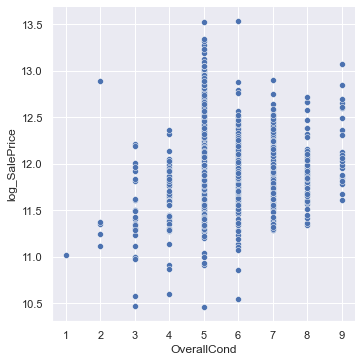

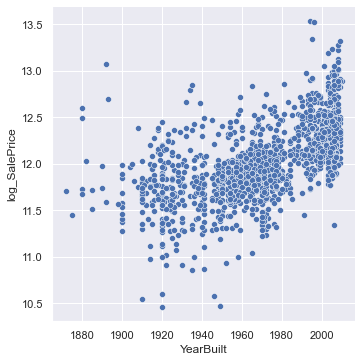

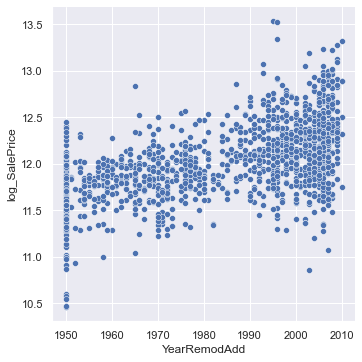

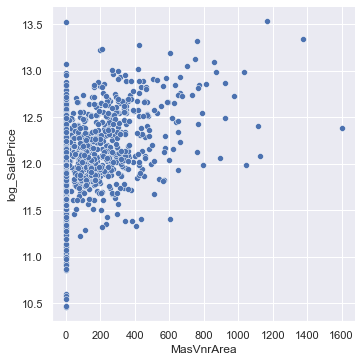

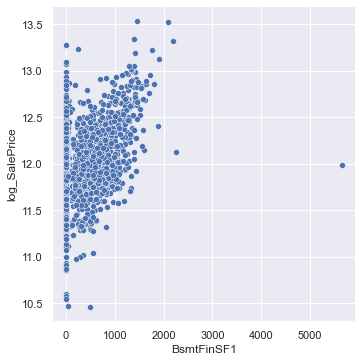

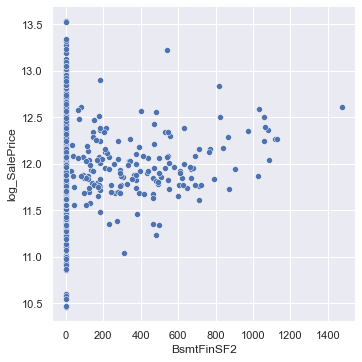

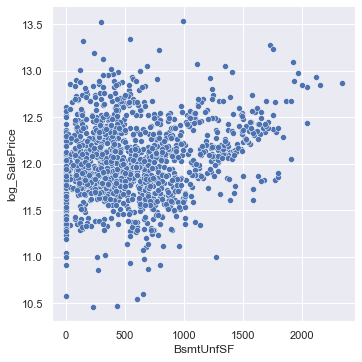

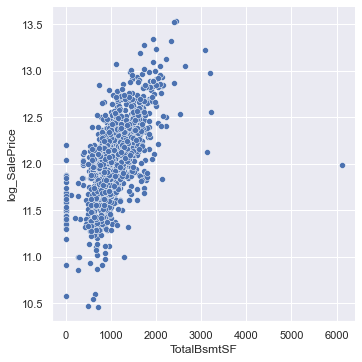

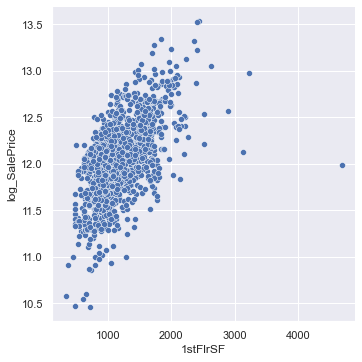

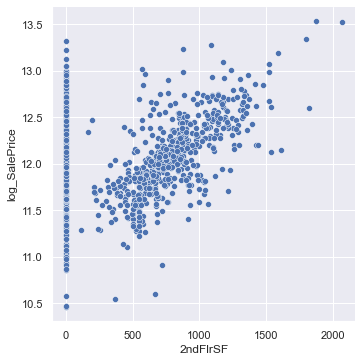

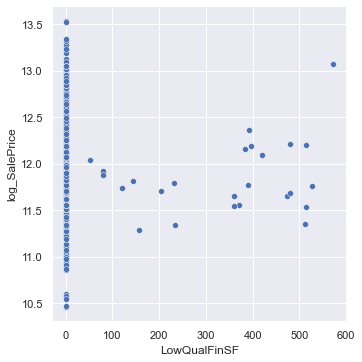

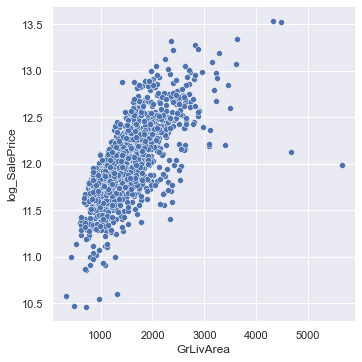

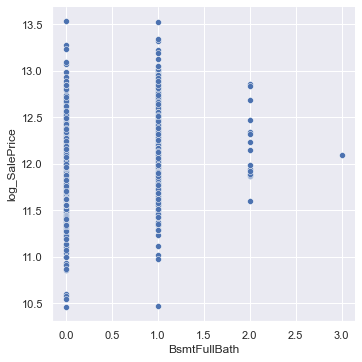

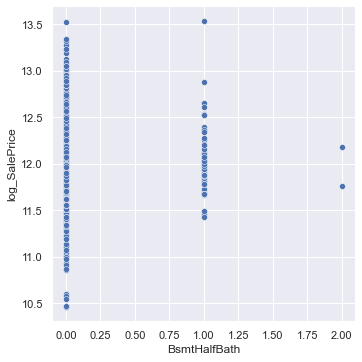

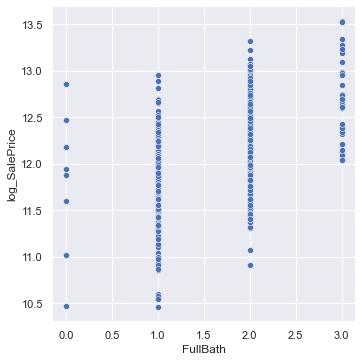

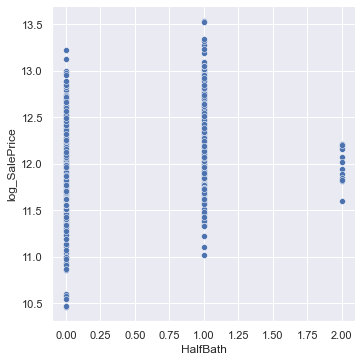

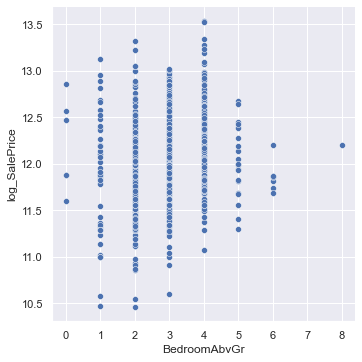

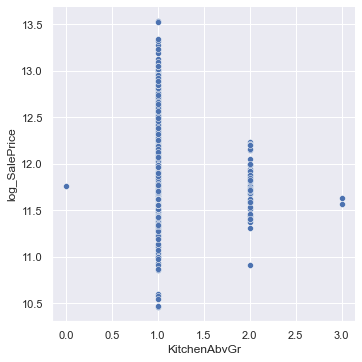

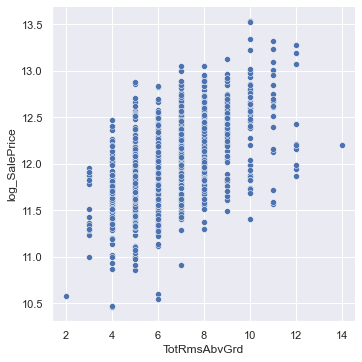

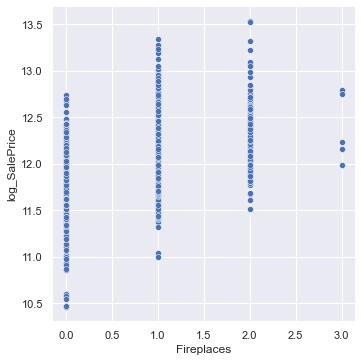

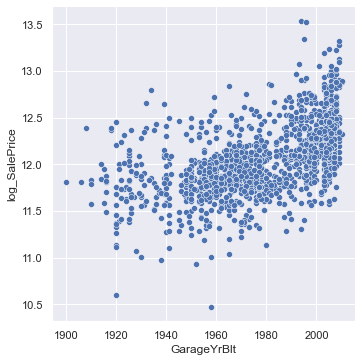

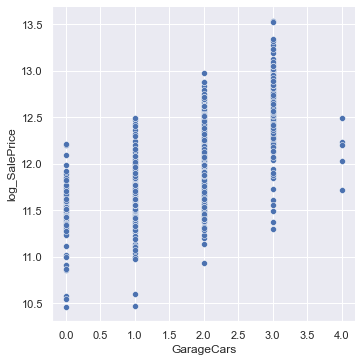

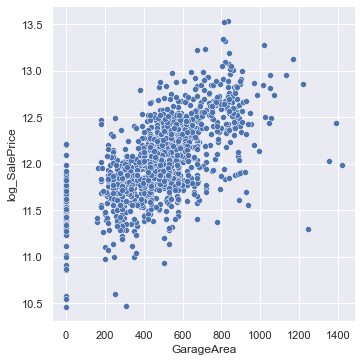

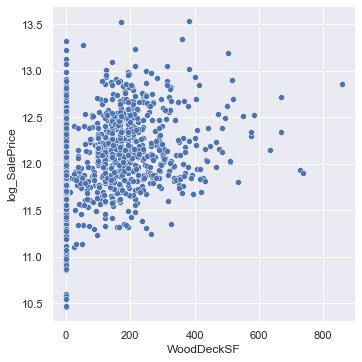

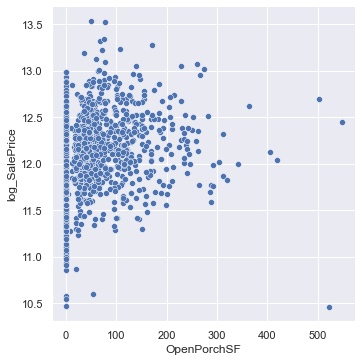

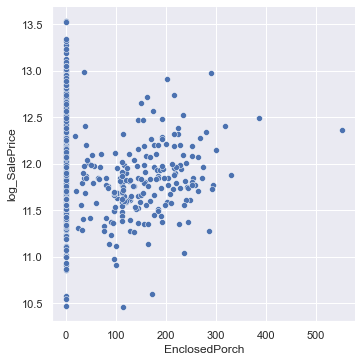

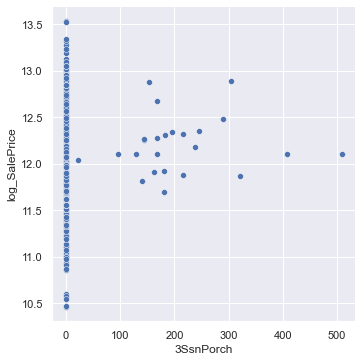

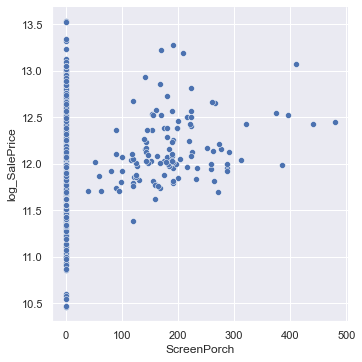

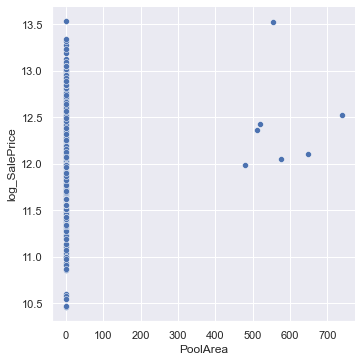

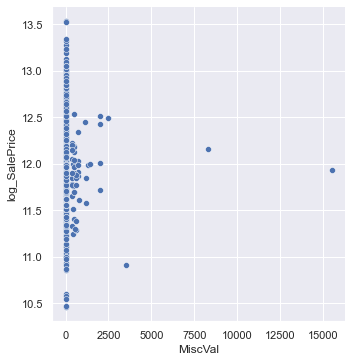

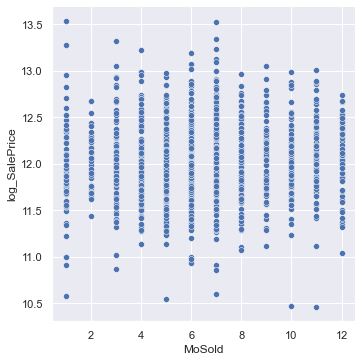

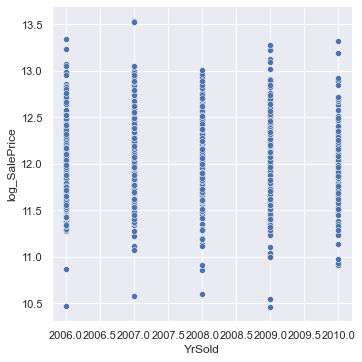

In [10]:
# exame the correlation with log_salePrice
for col in num_cols:
    sns.relplot(data=df_data, x=col, y="log_SalePrice")

/Users/ryansun/opt/anaconda3/envs/analytics37/lib/python3.7/site-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


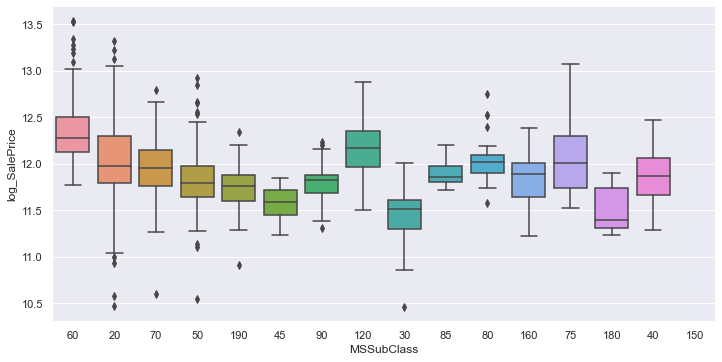

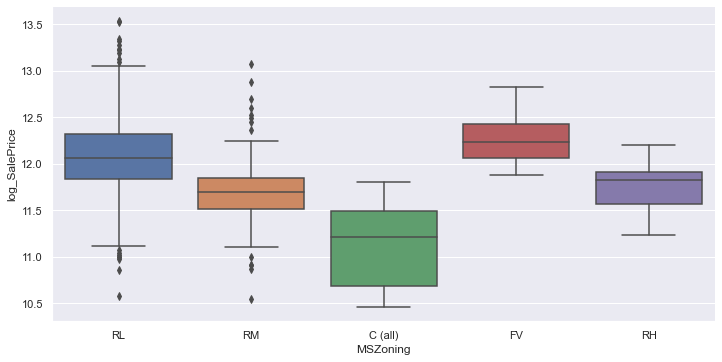

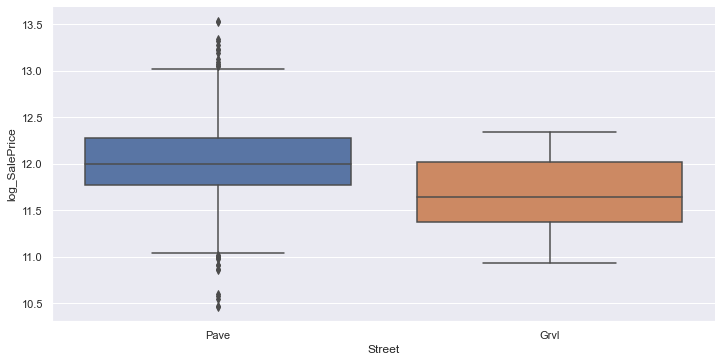

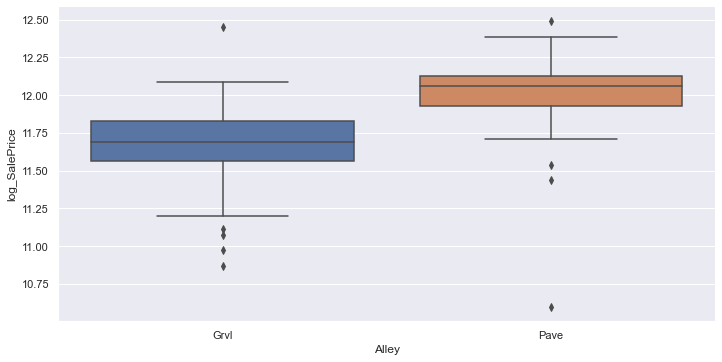

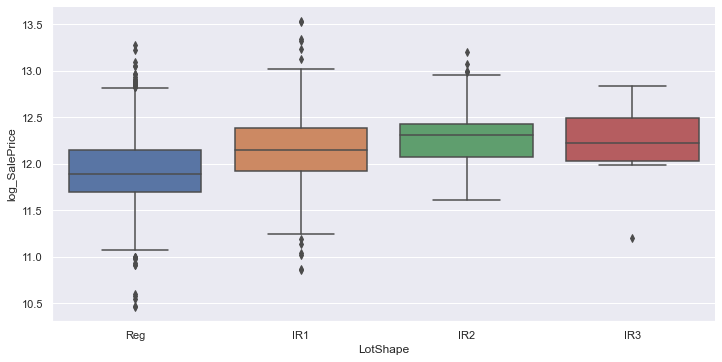

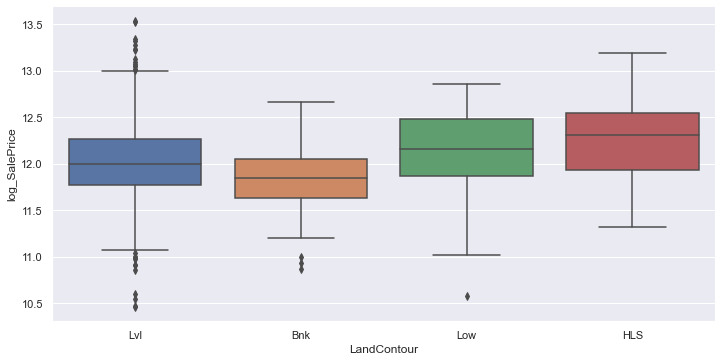

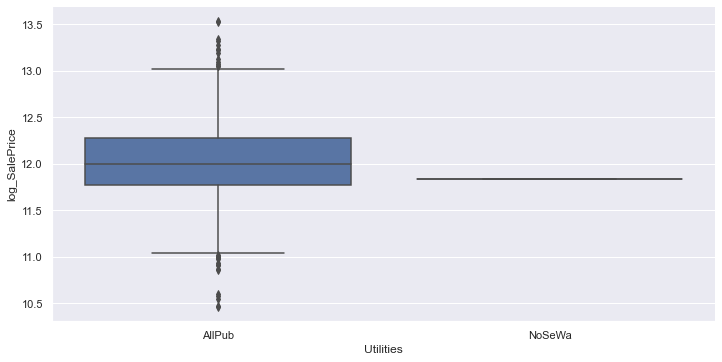

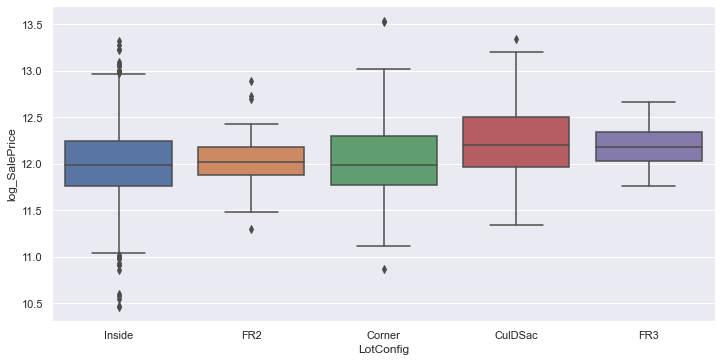

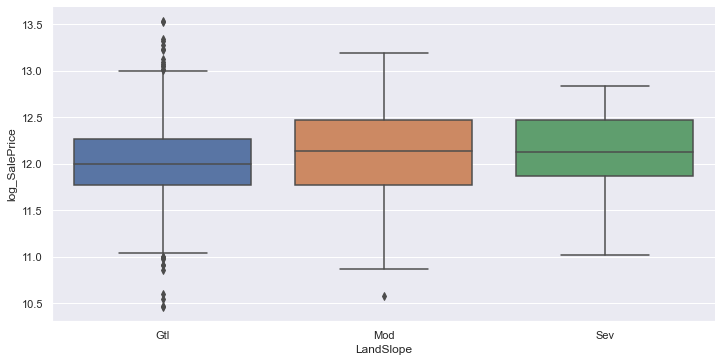

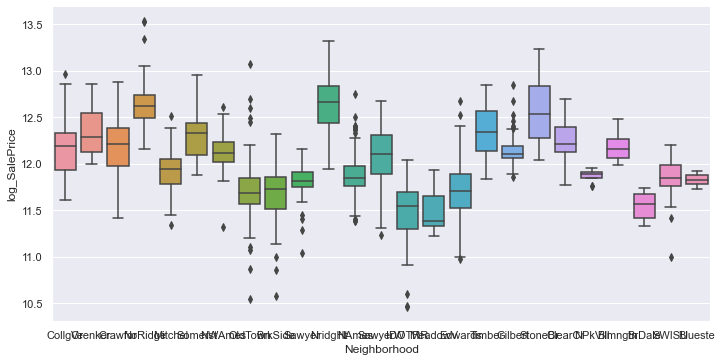

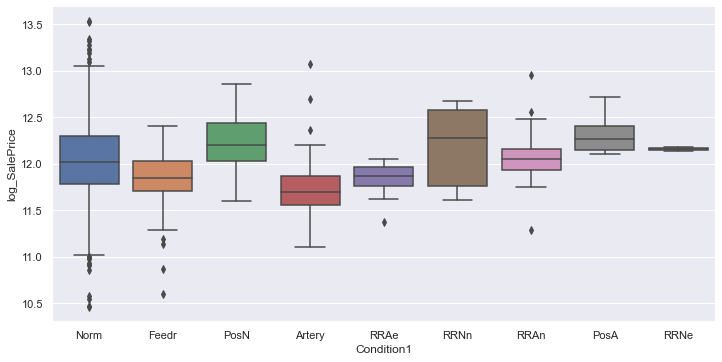

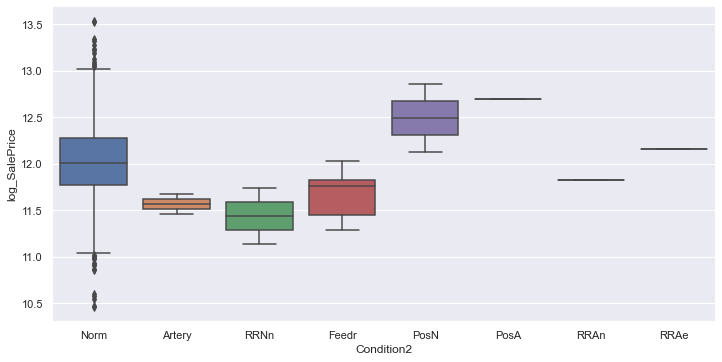

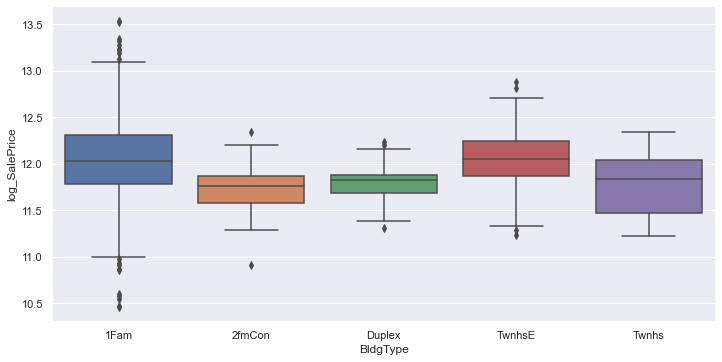

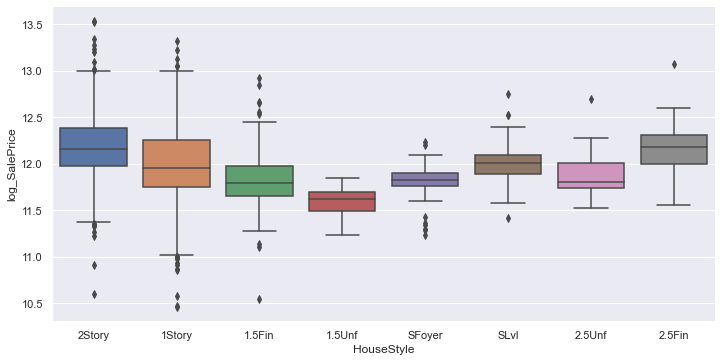

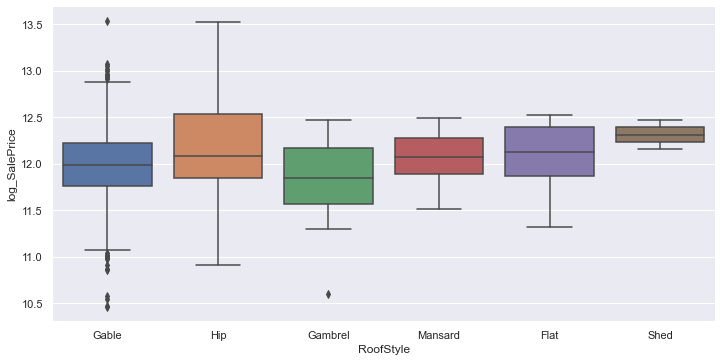

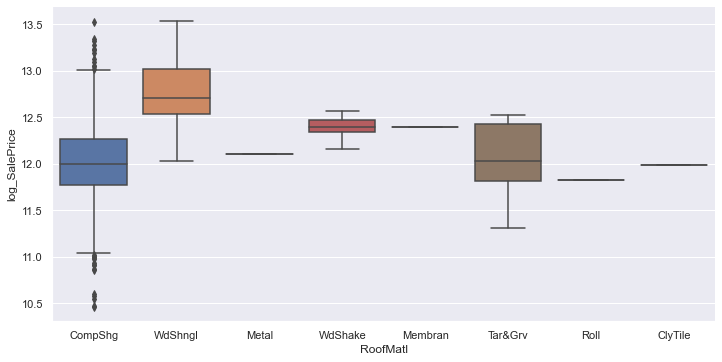

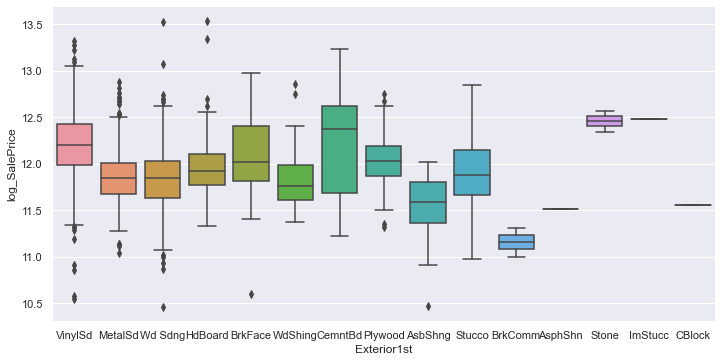

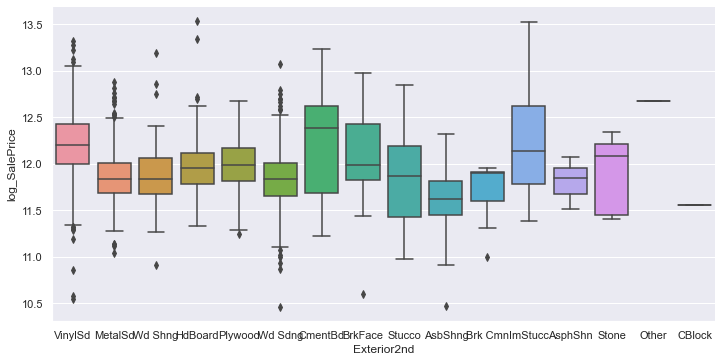

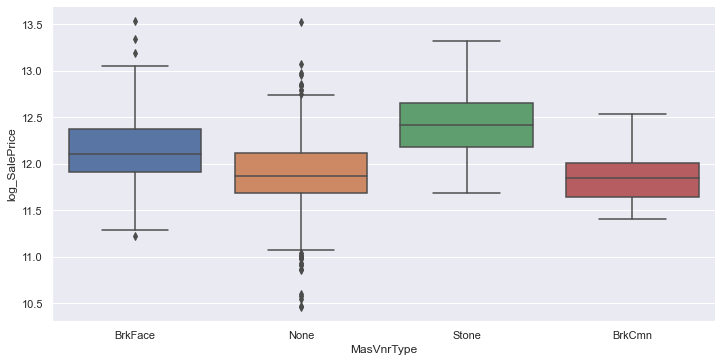

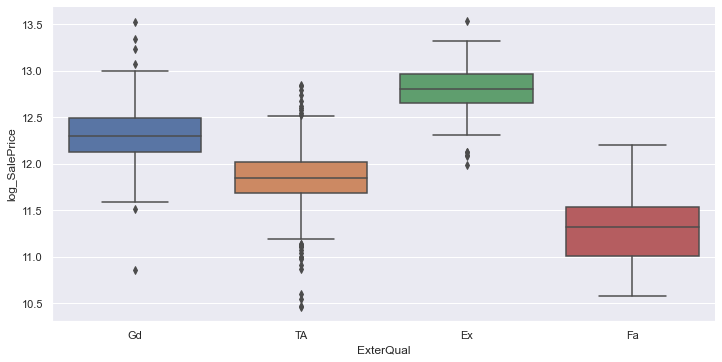

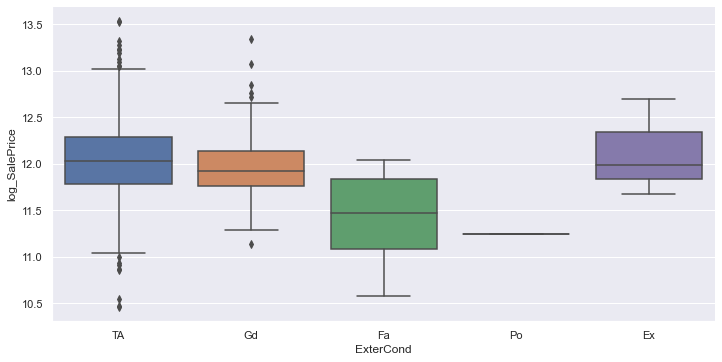

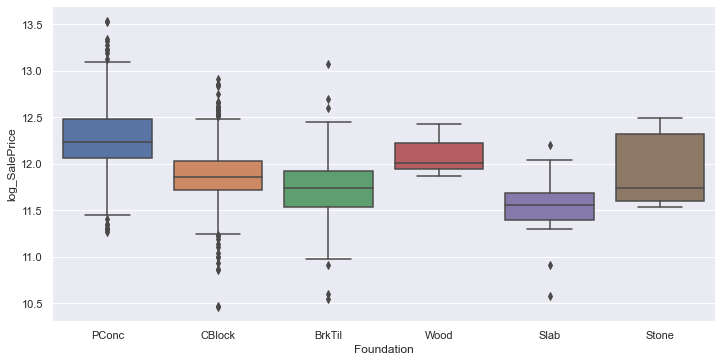

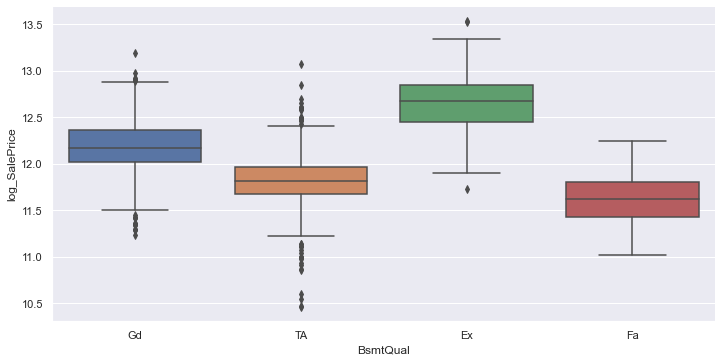

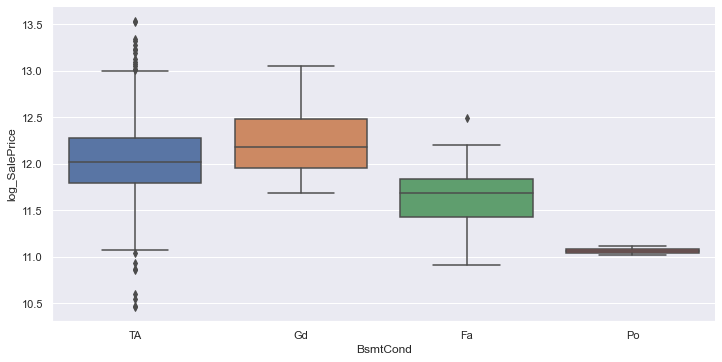

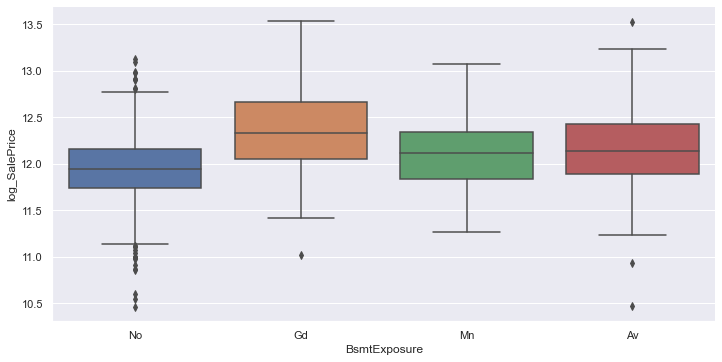

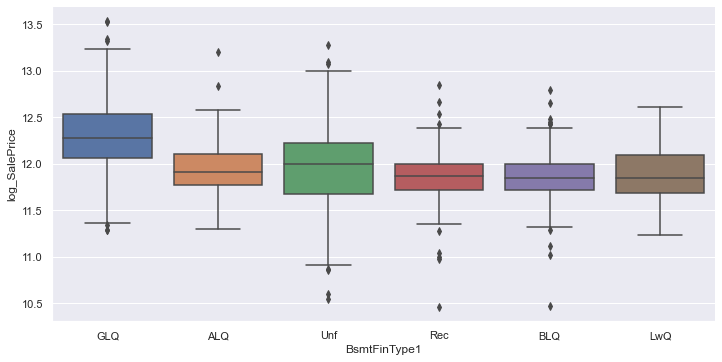

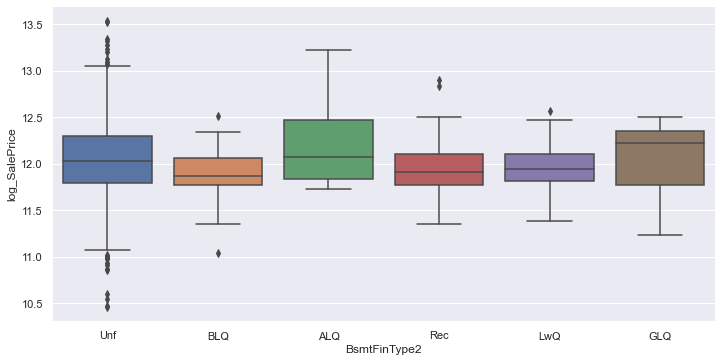

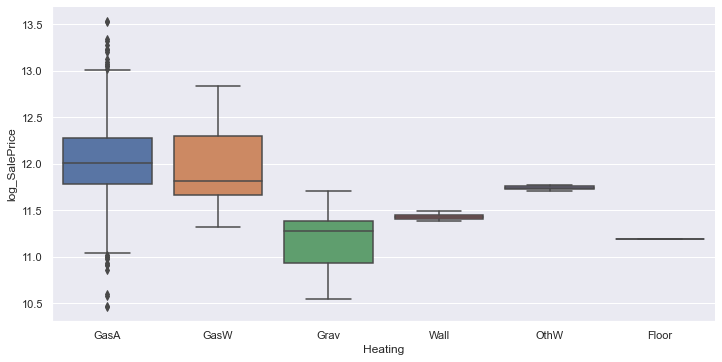

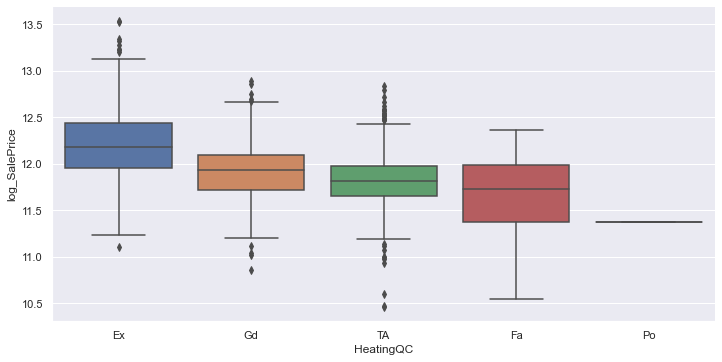

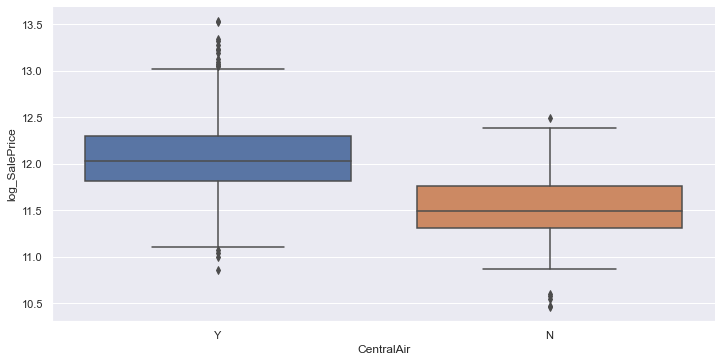

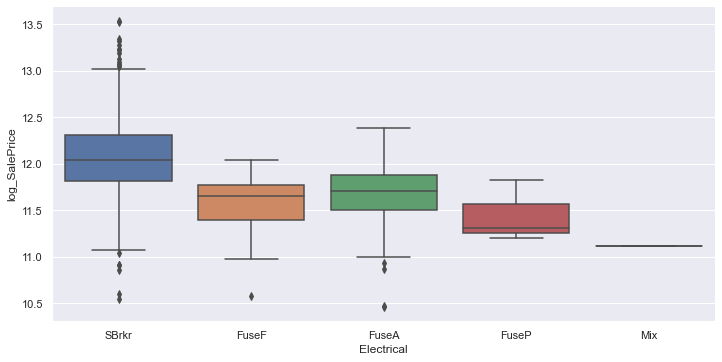

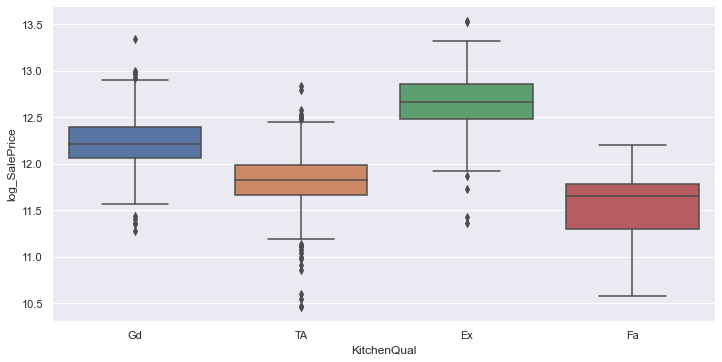

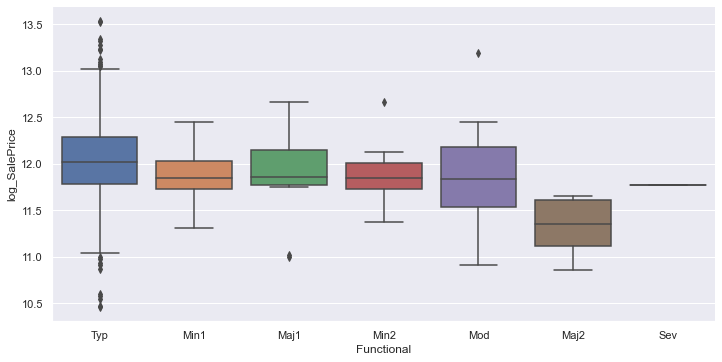

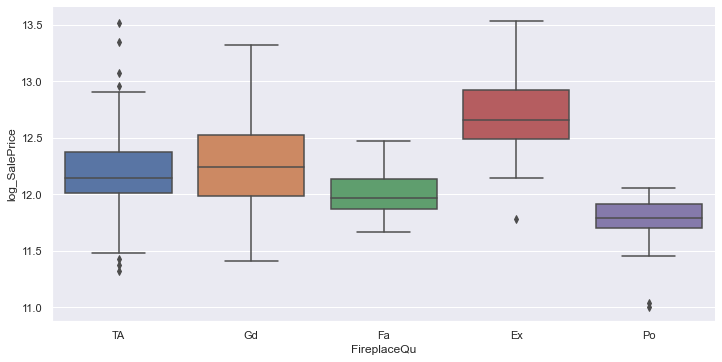

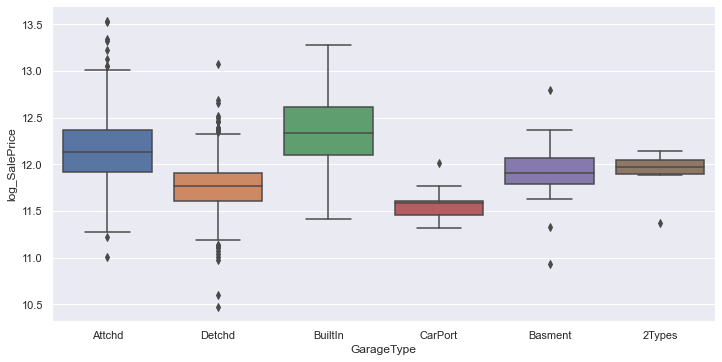

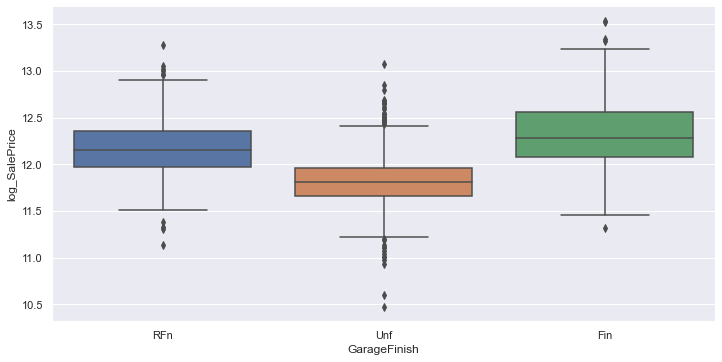

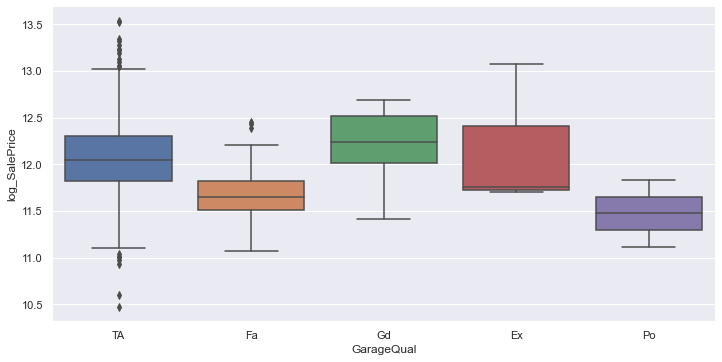

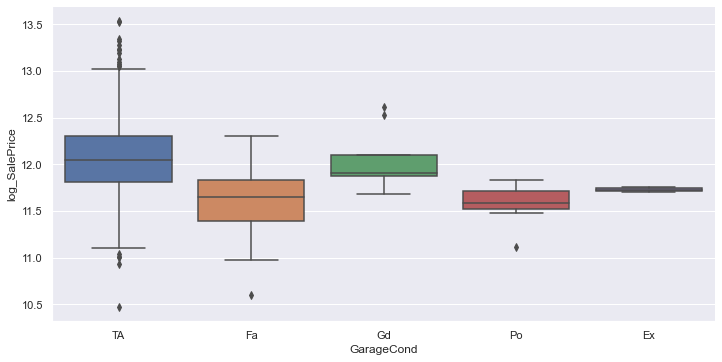

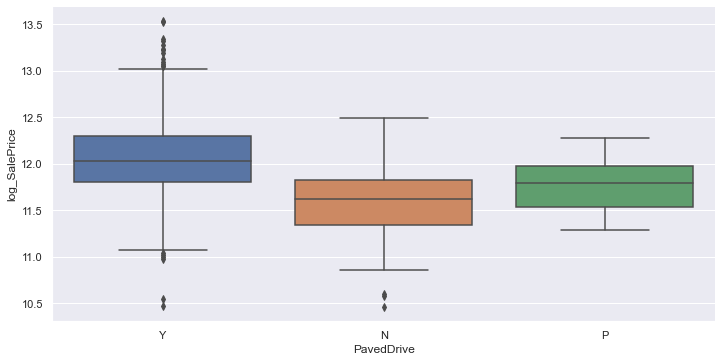

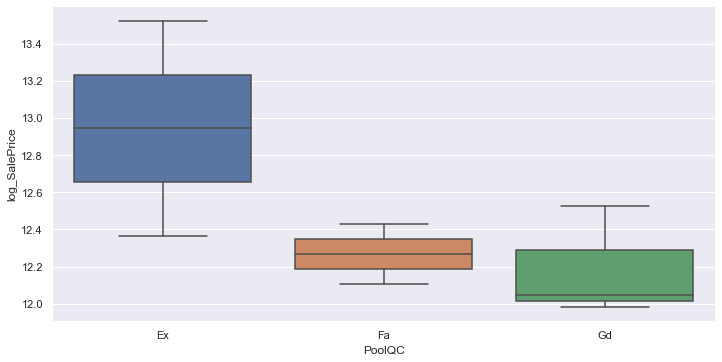

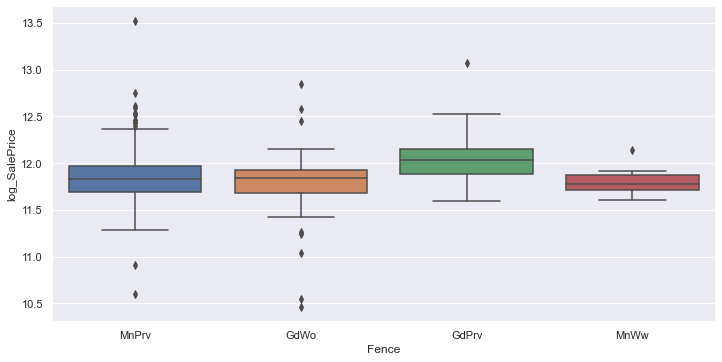

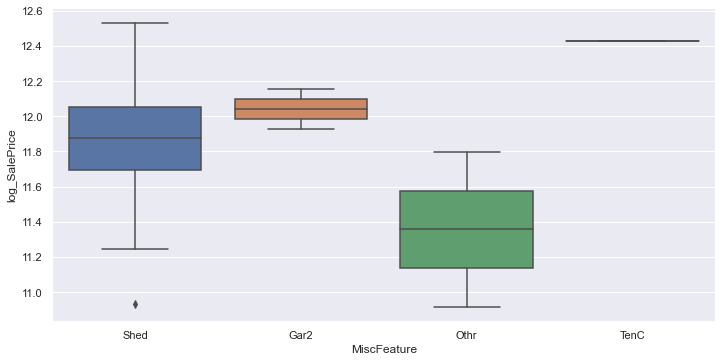

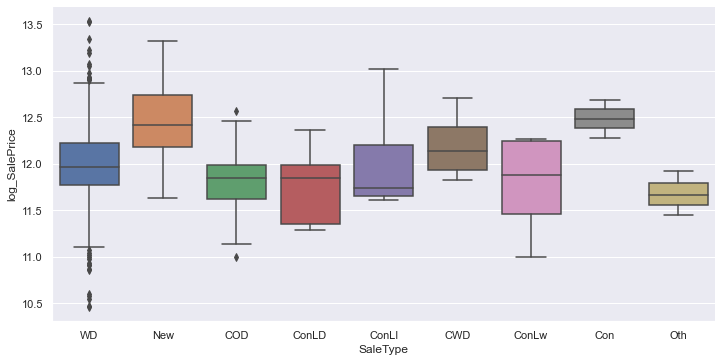

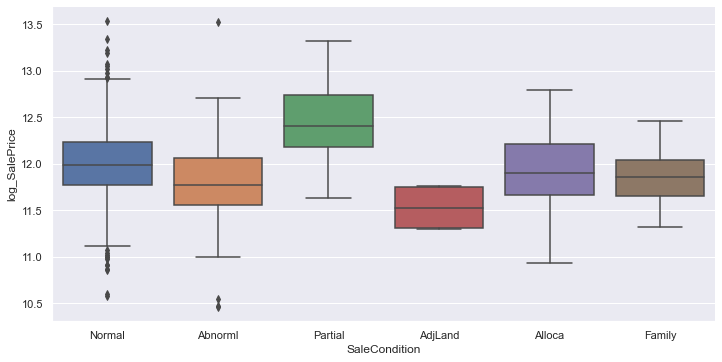

In [11]:
# investigate categorical variables
# col = 'MSZoning'
for col in cat_cols:
    sns.catplot(data=df_data, x=col, y = 'log_SalePrice', kind ='box', aspect=2)

<AxesSubplot:>

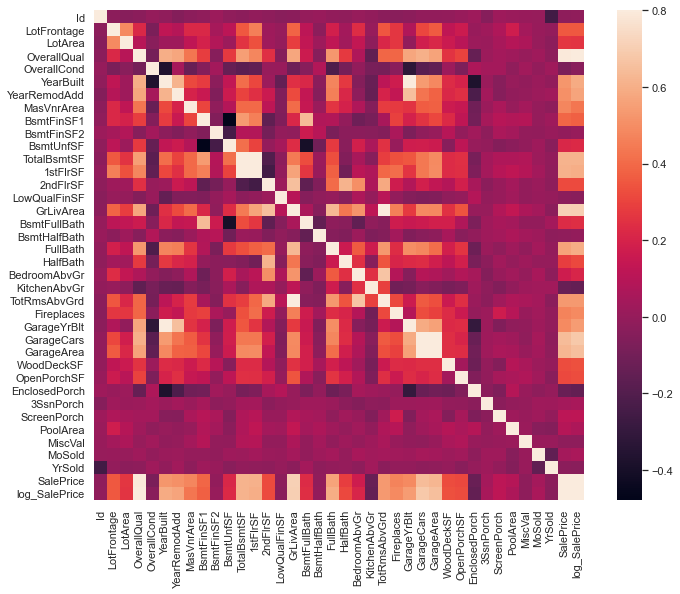

In [13]:
# correlation plot
corrmat = df_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

In [14]:
corrmat

Id  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageYrBlt  GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea   MiscVal    MoSold    YrSold  SalePrice  log_SalePrice
Id             1.000000    -0.027549 -0.040746    -0.029771    -0.002839  -0.016581     -0.050438   -0.025219   -0.016947    0.018251  -0.014453    -0.024924 -0.008678 -0.022252     -0.037816  -0.029046      0.000145      0.010387 -0.009946 -0.015358      0.003074     -0.011702     -0.029368   -0.035236    -0.026666   -0.010208   -0.008865   -0.007056     0.009960       0.021609  -0.046538     0.022208  0.014332  0.008244  0.006448 -0.256050  -0.021917      -0.017942
LotFrontage   -0.027549     1.000000  0.489896     0.217645    -0.075508   0.122811      0.091557    0.221079    0.219408    0.047431   0.113714     0.354822  0.458247  0.026545      0.004894   0.382462      0.113245     -0.025629  0.181668  0.039452      0.234892      0.004676      0.349513    0.261970     0.076673    0.310587    0.359786    0.122070     0.164896       0.011509   0.028289     0.075858  0.174119  0.044272  0.011254 -0.007917   0.351799       0.355878
LotArea       -0.040746     0.489896  1.000000     0.100541    -0.035617   0.024128      0.021612    0.125596    0.194031    0.084059   0.021362     0.254138  0.332460  0.031515      0.000554   0.284519      0.128349      0.026292  0.125826  0.034244      0.132801     -0.020854      0.213802    0.261185    -0.008628    0.180434    0.213251    0.158045     0.104797       0.020974   0.015995     0.054375  0.093708  0.069029  0.004156 -0.024234   0.263843       0.257320
OverallQual   -0.029771     0.217645  0.100541     1.000000    -0.093847   0.597554      0.571532    0.432947    0.281810   -0.042771   0.275175     0.549294  0.479152  0.245596     -0.048393   0.575126      0.164543     -0.040732  0.528483  0.272668      0.073075     -0.159325      0.389761    0.390753     0.571803    0.600744    0.565122    0.255317     0.298084      -0.139256   0.018715     0.042910  0.030740  0.005562  0.030405 -0.019614   0.790982       0.817184
OverallCond   -0.002839    -0.075508 -0.035617    -0.093847     1.000000  -0.368477      0.047654   -0.136007   -0.050418    0.041501  -0.138202    -0.174002 -0.157418  0.005494      0.009048  -0.116569     -0.042133      0.084181 -0.215504 -0.088577     -0.008477     -0.086700     -0.092027   -0.030999    -0.325849   -0.181787   -0.154149    0.020123    -0.068978       0.071044   0.043739     0.043713 -0.016876  0.033956 -0.006256  0.030102  -0.077856      -0.036868
...                 ...          ...       ...          ...          ...        ...           ...         ...         ...         ...        ...          ...       ...       ...           ...        ...           ...           ...       ...       ...           ...           ...           ...         ...          ...         ...         ...         ...          ...            ...        ...          ...       ...       ...       ...       ...        ...            ...
MiscVal        0.008244     0.044272  0.069029     0.005562     0.033956  -0.010886     -0.003124    0.044811    0.093295   -0.005139  -0.010492     0.084002  0.093062 -0.005299     -0.005973   0.067118     -0.004629      0.036902 -0.010024  0.026553      0.000245      0.025078      0.060903    0.008535    -0.009203   -0.016934    0.008446    0.056883     0.077357       0.008654  -0.000788     0.007067  0.011921  1.000000  0.007443  0.008445  -0.021190      -0.020021
MoSold         0.006448     0.011254  0.004156     0.030405    -0.006256   0.013938      0.017693   -0.000117   -0.000942   -0.009593   0.022607     0.017888  0.040143  0.014185      0.011528   0.044198     -0.003568      0.023014  0.046274 -0.0

<AxesSubplot:>

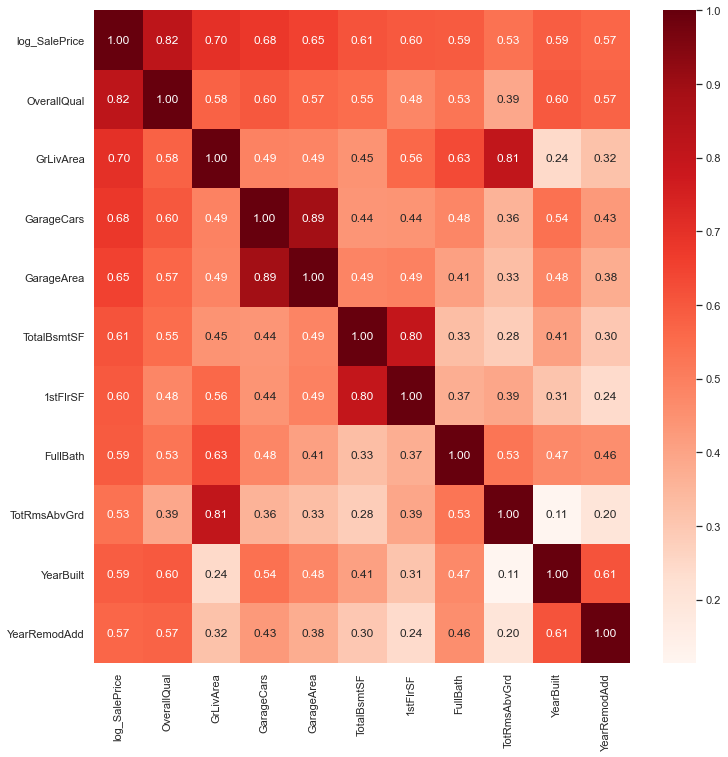

In [15]:
# corrmat
f, ax = plt.subplots(figsize=(12, 12))
k = 12 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cols = cols.drop("SalePrice") 
corrmat_selected = df_data[cols].corr()
sns.heatmap(corrmat_selected, annot=True, fmt='.2f', cmap = 'Reds')
# # hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
# plt.show()

In [15]:
# this kind of graph is not really needed; 
# sel_cols = ["log_SalePrice", "OverallQual", "GrLivArea"]
# sns.pairplot(df_data[sel_cols], height = 3)
# plt.show();

# handle missing values

• For categorical variable, fill the missing value with the correct meaning, or the most frequent value

• For numerical valriable, use the average value

In [16]:
df_data['PoolQC'] = df_data['PoolQC'].fillna('No Pool')
df_data['MiscFeature'] = df_data['MiscFeature'].fillna('None')
df_data['Alley'] = df_data['Alley'].fillna('No Alley Access')
df_data['Fence'] = df_data['Fence'].fillna('No Fence')
df_data['FireplaceQu'] = df_data['FireplaceQu'].fillna('No Fireplace')
df_data['LotFrontage'] = df_data['LotFrontage'].fillna(df_data['LotFrontage'].mean())  # fill missing using average value
df_data.loc[df_data['GarageYrBlt'].isnull(), 'GarageYrBlt'] = df_data['YearBuilt']     # use year built as a proxy when this field is missing
df_data['GarageType'] = df_data['GarageType'].fillna('No Garage')
df_data['GarageFinish'] = df_data['GarageType'].fillna('No Garage')
df_data['GarageQual'] = df_data['GarageQual'].fillna('No Garage')
df_data['GarageCond'] = df_data['GarageCond'].fillna('No Garage')

df_data.loc[(df_data['GarageType'] == 'No Garage') &
            (df_data['GarageArea'].isnull()), 'GarageArea']=0
df_data.loc[(df_data['GarageType'] != 'No Garage') &
            (df_data['GarageArea'].isnull()), 'GarageArea']= df_data['GarageArea'].mean()

df_data.loc[(df_data['GarageType'] == 'No Garage') &
            (df_data['GarageCars'].isnull()), 'GarageCars']=0
df_data.loc[(df_data['GarageType'] != 'No Garage') &
            (df_data['GarageCars'].isnull()), 'GarageCars']= df_data['GarageCars'].mean()

df_data['BsmtExposure'] = df_data['BsmtExposure'].fillna('No Basement')
df_data['BsmtFinType2'] = df_data['BsmtFinType2'].fillna('No Basement')
df_data['BsmtFinType1'] = df_data['BsmtFinType1'].fillna('No Basement')
df_data['BsmtQual'] = df_data['BsmtQual'].fillna('No Basement')
df_data['BsmtCond'] = df_data['BsmtCond'].fillna('No Basement')

df_data.loc[(df_data['BsmtCond'] == 'No Basement') & 
            (df_data['BsmtFinSF1'].isnull()), 'BsmtFinSF1'] = 0 
df_data.loc[(df_data['BsmtCond'] == 'No Basement') & 
            (df_data['BsmtFinSF2'].isnull()), 'BsmtFinSF2'] = 0 
df_data.loc[(df_data['BsmtCond'] == 'No Basement') & 
            (df_data['BsmtUnfSF'].isnull()), 'BsmtUnfSF'] = 0 
df_data.loc[(df_data['BsmtCond'] == 'No Basement') & 
            (df_data['TotalBsmtSF'].isnull()), 'TotalBsmtSF'] = 0 
df_data.loc[(df_data['BsmtCond'] == 'No Basement') & 
            (df_data['BsmtFullBath'].isnull()), 'BsmtFullBath'] = 0 
df_data.loc[(df_data['BsmtCond'] == 'No Basement') & 
            (df_data['BsmtHalfBath'].isnull()), 'BsmtHalfBath'] = 0 

df_data['MasVnrType'] = df_data['MasVnrType'].fillna('None')
df_data['MasVnrArea'] = df_data['MasVnrArea'].fillna(0)

imp_freq = SimpleImputer(strategy='most_frequent')
df_data['Electrical'] = imp_freq.fit_transform(df_data[['Electrical']])
df_data['Functional'] = imp_freq.fit_transform(df_data[['Functional']])
df_data['MSZoning'] = imp_freq.fit_transform(df_data[['MSZoning']])
df_data['Utilities'] = imp_freq.fit_transform(df_data[['Utilities']])
df_data['SaleType'] = imp_freq.fit_transform(df_data[['SaleType']])
df_data['KitchenQual'] = imp_freq.fit_transform(df_data[['KitchenQual']])
df_data['Exterior1st'] = imp_freq.fit_transform(df_data[['Exterior1st']])
df_data['Exterior2nd'] = imp_freq.fit_transform(df_data[['Exterior2nd']])

In [17]:
df_data[df_data['Exterior1st'].isnull()]
df_data.groupby('Exterior2nd')['Id'].count()

Exterior2nd
AsbShng      38
AsphShn       4
Brk Cmn      22
BrkFace      47
CBlock        3
CmentBd     126
HdBoard     406
ImStucc      15
MetalSd     447
Other         1
Plywood     270
Stone         6
Stucco       47
VinylSd    1015
Wd Sdng     391
Wd Shng      81
Name: Id, dtype: int64

In [18]:
def data_fill_rate(df):
    fill = df.notnull().sum()
    df_fill = fill.to_frame()
    df_fill.rename(columns = {0: 'filled'}, inplace=True)
    df_fill['total'] = df.shape[0]
    df_fill['fill_rate'] = df_fill['filled']/ df_fill['total']
    df_types = df.dtypes.to_frame('dtypes')
    df_fill = pd.merge(left=df_fill, right= df_types, left_index =True, right_index=True, how='outer')
    return df_fill
df_fill_rate= data_fill_rate(df_data)
df_fill_rate[df_fill_rate['fill_rate']<1].sort_values(by ='fill_rate', ascending=True)

filled  total  fill_rate   dtypes
SalePrice        1460   2919   0.500171  float64
log_SalePrice    1460   2919   0.500171  float64

# one hot encoding

In [19]:
df_data_1 = pd.get_dummies(df_data, columns = cat_cols, prefix = cat_cols, drop_first=False)

In [20]:
cat_encoding_cols = []
for col in df_data_1.columns:
    if df_data_1[col].dtypes =='uint8':
        cat_encoding_cols.append(col)

In [21]:
df_data_1

Id  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageYrBlt  GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  SalePrice  log_SalePrice  MSSubClass_120  MSSubClass_150  MSSubClass_160  MSSubClass_180  MSSubClass_190  MSSubClass_20  MSSubClass_30  MSSubClass_40  MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  Street_Grvl  Street_Pave  Alley_Grvl  Alley_No Alley Access  Alley_Pave  LotShape_IR1  LotShape_IR2  LotShape_IR3  LotShape_Reg  LandContour_Bnk  LandContour_HLS  LandContour_Low  LandContour_Lvl  Utilities_AllPub  \
0        1         65.0     8450            7            5       2003          2003       196.0       706.0         0.0      150.0        856.0       856       854             0       1710           1.0           0.0         2         1             3             1             8           0       2003.0         2.0       548.0           0           61              0          0            0         0        0       2    2008   208500.0      12.247694               0               0               0               0               0              0              0              0              0              0              1              0              0              0              0              0                 0            0            0            1            0            0            1           0                      1           0             0             0             0             1                0                0                0                1                 1   
1        2         80.0     9600            6            8       1976          1976         0.0       978.0         0.0      284.0       1262.0      1262         0             0       1262           0.0           1.0         2         0             3             1             6           1       1976.0         2.0       460.0         298            0              0          0            0         0        0       5    2007   181500.0      12.109011               0               0               0               0               0              1              0              0              0              0              0              0              0              0              0              0                 0            0            0            1            0            0            1           0                      1           0             0             0             0             1                0                0                0                1                 1   
2        3         68.0    11250            7            5       2001          2002       162.0       486.0         0.0      434.0        920.0       920       866             0       1786           1.0           0.0         2         1             3             1             6           1       2001.0         2.0       608.0           0           42              0          0            0         0        0       9    2008   223500.0      12.317167               0               0               0               0               0              0              0              0              0              0              1              0              0              0              0              0                 0            0            0            1            0            0            1           0                      1           0             1             0             0             0                0                0                0                1                 1   
3        4         60.0     9550            7            5      

In [22]:
var_cols = num_cols + cat_encoding_cols
# var_cols

In [23]:
df_data_1.head()

Id  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageYrBlt  GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  SalePrice  log_SalePrice  MSSubClass_120  MSSubClass_150  MSSubClass_160  MSSubClass_180  MSSubClass_190  MSSubClass_20  MSSubClass_30  MSSubClass_40  MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  Street_Grvl  Street_Pave  Alley_Grvl  Alley_No Alley Access  Alley_Pave  LotShape_IR1  LotShape_IR2  LotShape_IR3  LotShape_Reg  LandContour_Bnk  LandContour_HLS  LandContour_Low  LandContour_Lvl  Utilities_AllPub  Utilities_NoSeWa  \
0   1         65.0     8450            7            5       2003          2003       196.0       706.0         0.0      150.0        856.0       856       854             0       1710           1.0           0.0         2         1             3             1             8           0       2003.0         2.0       548.0           0           61              0          0            0         0        0       2    2008   208500.0      12.247694               0               0               0               0               0              0              0              0              0              0              1              0              0              0              0              0                 0            0            0            1            0            0            1           0                      1           0             0             0             0             1                0                0                0                1                 1                 0   
1   2         80.0     9600            6            8       1976          1976         0.0       978.0         0.0      284.0       1262.0      1262         0             0       1262           0.0           1.0         2         0             3             1             6           1       1976.0         2.0       460.0         298            0              0          0            0         0        0       5    2007   181500.0      12.109011               0               0               0               0               0              1              0              0              0              0              0              0              0              0              0              0                 0            0            0            1            0            0            1           0                      1           0             0             0             0             1                0                0                0                1                 1                 0   
2   3         68.0    11250            7            5       2001          2002       162.0       486.0         0.0      434.0        920.0       920       866             0       1786           1.0           0.0         2         1             3             1             6           1       2001.0         2.0       608.0           0           42              0          0            0         0        0       9    2008   223500.0      12.317167               0               0               0               0               0              0              0              0              0              0              1              0              0              0              0              0                 0            0            0            1            0            0            1           0                      1           0             1             0             0             0                0                0                0                1                 1                 0   
3   4  

In [24]:
df_train_1 = df_data_1[df_data_1['SalePrice'].notnull()].copy()
df_test_1 = df_data_1[df_data_1['SalePrice'].isnull()].copy()

In [25]:
df_train_1.shape

(1460, 323)

# Modeling: Xgboost + Gridsearch

In [26]:
df_seg_train, df_seg_test = train_test_split(df_train_1, test_size = 0.2, random_state=42)

X_train = df_seg_train[var_cols]
y_train = df_seg_train['log_SalePrice']

X_test = df_seg_test[var_cols]
y_test = df_seg_test['log_SalePrice']

In [27]:
# fine tune the XGboost model hyper parameters
param_grid = [{'colsample_bytree': [0.7, 0.6, 0.5, 0.4],
               'eta': [0.01, 0.05, 0.1],
               'max_depth': [2,4,6],
               'n_estimators': [600, 700, 800],
               'subsample': [ 0.8, 0.6, 0.4],
              }]
# param_grid = [{'colsample_bytree': [0.7, 0.6, 0.5],
#                'eta': [0.05],
#                'max_depth': [2,4,6],
#                'n_estimators': [700, 800, 900],
#                'subsample': [0.7, 0.6, 0.5],
#               }]
model = xgb.XGBRegressor()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring = 'neg_root_mean_squared_error', verbose=3)

In [28]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] colsample_bytree=0.7, eta=0.01, max_depth=2, n_estimators=600, subsample=0.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.7, eta=0.01, max_depth=2, n_estimators=600, subsample=0.8, score=-0.148, total=   0.8s
[CV] colsample_bytree=0.7, eta=0.01, max_depth=2, n_estimators=600, subsample=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  colsample_bytree=0.7, eta=0.01, max_depth=2, n_estimators=600, subsample=0.8, score=-0.154, total=   1.0s
[CV] colsample_bytree=0.7, eta=0.01, max_depth=2, n_estimators=600, subsample=0.8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s


[CV]  colsample_bytree=0.7, eta=0.01, max_depth=2, n_estimators=600, subsample=0.8, score=-0.174, total=   0.8s
[CV] colsample_bytree=0.7, eta=0.01, max_depth=2, n_estimators=600, subsample=0.8 
[CV]  colsample_bytree=0.7, eta=0.01, max_depth=2, n_estimators=600, subsample=0.8, score=-0.144, total=   1.0s
[CV] colsample_bytree=0.7, eta=0.01, max_depth=2, n_estimators=600, subsample=0.8 
[CV]  colsample_bytree=0.7, eta=0.01, max_depth=2, n_estimators=600, subsample=0.8, score=-0.128, total=   0.9s
[CV] colsample_bytree=0.7, eta=0.01, max_depth=2, n_estimators=600, subsample=0.6 
[CV]  colsample_bytree=0.7, eta=0.01, max_depth=2, n_estimators=600, subsample=0.6, score=-0.148, total=   1.3s
[CV] colsample_bytree=0.7, eta=0.01, max_depth=2, n_estimators=600, subsample=0.6 
[CV]  colsample_bytree=0.7, eta=0.01, max_depth=2, n_estimators=600, subsample=0.6, score=-0.155, total=   1.1s
[CV] colsample_bytree=0.7, eta=0.01, max_depth=2, n_estimators=600, subsample=0.6 
[CV]  colsample_bytree=0.

[CV]  colsample_bytree=0.7, eta=0.01, max_depth=4, n_estimators=600, subsample=0.8, score=-0.143, total=   1.5s
[CV] colsample_bytree=0.7, eta=0.01, max_depth=4, n_estimators=600, subsample=0.8 
[CV]  colsample_bytree=0.7, eta=0.01, max_depth=4, n_estimators=600, subsample=0.8, score=-0.148, total=   1.4s
[CV] colsample_bytree=0.7, eta=0.01, max_depth=4, n_estimators=600, subsample=0.8 
[CV]  colsample_bytree=0.7, eta=0.01, max_depth=4, n_estimators=600, subsample=0.8, score=-0.156, total=   1.4s
[CV] colsample_bytree=0.7, eta=0.01, max_depth=4, n_estimators=600, subsample=0.8 
[CV]  colsample_bytree=0.7, eta=0.01, max_depth=4, n_estimators=600, subsample=0.8, score=-0.134, total=   1.6s
[CV] colsample_bytree=0.7, eta=0.01, max_depth=4, n_estimators=600, subsample=0.8 
[CV]  colsample_bytree=0.7, eta=0.01, max_depth=4, n_estimators=600, subsample=0.8, score=-0.121, total=   1.6s
[CV] colsample_bytree=0.7, eta=0.01, max_depth=4, n_estimators=600, subsample=0.6 
[CV]  colsample_bytree=0.

[CV]  colsample_bytree=0.7, eta=0.01, max_depth=4, n_estimators=800, subsample=0.4, score=-0.122, total=   2.0s
[CV] colsample_bytree=0.7, eta=0.01, max_depth=4, n_estimators=800, subsample=0.4 
[CV]  colsample_bytree=0.7, eta=0.01, max_depth=4, n_estimators=800, subsample=0.4, score=-0.109, total=   2.1s
[CV] colsample_bytree=0.7, eta=0.01, max_depth=6, n_estimators=600, subsample=0.8 
[CV]  colsample_bytree=0.7, eta=0.01, max_depth=6, n_estimators=600, subsample=0.8, score=-0.142, total=   2.4s
[CV] colsample_bytree=0.7, eta=0.01, max_depth=6, n_estimators=600, subsample=0.8 
[CV]  colsample_bytree=0.7, eta=0.01, max_depth=6, n_estimators=600, subsample=0.8, score=-0.145, total=   2.8s
[CV] colsample_bytree=0.7, eta=0.01, max_depth=6, n_estimators=600, subsample=0.8 
[CV]  colsample_bytree=0.7, eta=0.01, max_depth=6, n_estimators=600, subsample=0.8, score=-0.152, total=   2.3s
[CV] colsample_bytree=0.7, eta=0.01, max_depth=6, n_estimators=600, subsample=0.8 
[CV]  colsample_bytree=0.

[CV]  colsample_bytree=0.7, eta=0.01, max_depth=6, n_estimators=800, subsample=0.4, score=-0.145, total=   3.5s
[CV] colsample_bytree=0.7, eta=0.01, max_depth=6, n_estimators=800, subsample=0.4 
[CV]  colsample_bytree=0.7, eta=0.01, max_depth=6, n_estimators=800, subsample=0.4, score=-0.145, total=   4.4s
[CV] colsample_bytree=0.7, eta=0.01, max_depth=6, n_estimators=800, subsample=0.4 
[CV]  colsample_bytree=0.7, eta=0.01, max_depth=6, n_estimators=800, subsample=0.4, score=-0.122, total=   2.5s
[CV] colsample_bytree=0.7, eta=0.01, max_depth=6, n_estimators=800, subsample=0.4 
[CV]  colsample_bytree=0.7, eta=0.01, max_depth=6, n_estimators=800, subsample=0.4, score=-0.108, total=   2.6s
[CV] colsample_bytree=0.7, eta=0.05, max_depth=2, n_estimators=600, subsample=0.8 
[CV]  colsample_bytree=0.7, eta=0.05, max_depth=2, n_estimators=600, subsample=0.8, score=-0.128, total=   1.5s
[CV] colsample_bytree=0.7, eta=0.05, max_depth=2, n_estimators=600, subsample=0.8 
[CV]  colsample_bytree=0.

[CV]  colsample_bytree=0.7, eta=0.05, max_depth=2, n_estimators=800, subsample=0.6, score=-0.108, total=   4.0s
[CV] colsample_bytree=0.7, eta=0.05, max_depth=2, n_estimators=800, subsample=0.4 
[CV]  colsample_bytree=0.7, eta=0.05, max_depth=2, n_estimators=800, subsample=0.4, score=-0.124, total=   3.2s
[CV] colsample_bytree=0.7, eta=0.05, max_depth=2, n_estimators=800, subsample=0.4 
[CV]  colsample_bytree=0.7, eta=0.05, max_depth=2, n_estimators=800, subsample=0.4, score=-0.145, total=   3.2s
[CV] colsample_bytree=0.7, eta=0.05, max_depth=2, n_estimators=800, subsample=0.4 
[CV]  colsample_bytree=0.7, eta=0.05, max_depth=2, n_estimators=800, subsample=0.4, score=-0.138, total=   3.4s
[CV] colsample_bytree=0.7, eta=0.05, max_depth=2, n_estimators=800, subsample=0.4 
[CV]  colsample_bytree=0.7, eta=0.05, max_depth=2, n_estimators=800, subsample=0.4, score=-0.123, total=   4.5s
[CV] colsample_bytree=0.7, eta=0.05, max_depth=2, n_estimators=800, subsample=0.4 
[CV]  colsample_bytree=0.

[CV]  colsample_bytree=0.7, eta=0.05, max_depth=4, n_estimators=800, subsample=0.6, score=-0.138, total=   2.5s
[CV] colsample_bytree=0.7, eta=0.05, max_depth=4, n_estimators=800, subsample=0.6 
[CV]  colsample_bytree=0.7, eta=0.05, max_depth=4, n_estimators=800, subsample=0.6, score=-0.117, total=   2.0s
[CV] colsample_bytree=0.7, eta=0.05, max_depth=4, n_estimators=800, subsample=0.6 
[CV]  colsample_bytree=0.7, eta=0.05, max_depth=4, n_estimators=800, subsample=0.6, score=-0.106, total=   2.3s
[CV] colsample_bytree=0.7, eta=0.05, max_depth=4, n_estimators=800, subsample=0.4 
[CV]  colsample_bytree=0.7, eta=0.05, max_depth=4, n_estimators=800, subsample=0.4, score=-0.120, total=   2.0s
[CV] colsample_bytree=0.7, eta=0.05, max_depth=4, n_estimators=800, subsample=0.4 
[CV]  colsample_bytree=0.7, eta=0.05, max_depth=4, n_estimators=800, subsample=0.4, score=-0.140, total=   2.6s
[CV] colsample_bytree=0.7, eta=0.05, max_depth=4, n_estimators=800, subsample=0.4 
[CV]  colsample_bytree=0.

[CV]  colsample_bytree=0.7, eta=0.05, max_depth=6, n_estimators=800, subsample=0.6, score=-0.126, total=   2.6s
[CV] colsample_bytree=0.7, eta=0.05, max_depth=6, n_estimators=800, subsample=0.6 
[CV]  colsample_bytree=0.7, eta=0.05, max_depth=6, n_estimators=800, subsample=0.6, score=-0.147, total=   2.5s
[CV] colsample_bytree=0.7, eta=0.05, max_depth=6, n_estimators=800, subsample=0.6 
[CV]  colsample_bytree=0.7, eta=0.05, max_depth=6, n_estimators=800, subsample=0.6, score=-0.143, total=   2.6s
[CV] colsample_bytree=0.7, eta=0.05, max_depth=6, n_estimators=800, subsample=0.6 
[CV]  colsample_bytree=0.7, eta=0.05, max_depth=6, n_estimators=800, subsample=0.6, score=-0.119, total=   2.6s
[CV] colsample_bytree=0.7, eta=0.05, max_depth=6, n_estimators=800, subsample=0.6 
[CV]  colsample_bytree=0.7, eta=0.05, max_depth=6, n_estimators=800, subsample=0.6, score=-0.107, total=   2.8s
[CV] colsample_bytree=0.7, eta=0.05, max_depth=6, n_estimators=800, subsample=0.4 
[CV]  colsample_bytree=0.

[CV]  colsample_bytree=0.7, eta=0.1, max_depth=2, n_estimators=800, subsample=0.8, score=-0.123, total=   1.3s
[CV] colsample_bytree=0.7, eta=0.1, max_depth=2, n_estimators=800, subsample=0.8 
[CV]  colsample_bytree=0.7, eta=0.1, max_depth=2, n_estimators=800, subsample=0.8, score=-0.107, total=   1.2s
[CV] colsample_bytree=0.7, eta=0.1, max_depth=2, n_estimators=800, subsample=0.6 
[CV]  colsample_bytree=0.7, eta=0.1, max_depth=2, n_estimators=800, subsample=0.6, score=-0.129, total=   1.3s
[CV] colsample_bytree=0.7, eta=0.1, max_depth=2, n_estimators=800, subsample=0.6 
[CV]  colsample_bytree=0.7, eta=0.1, max_depth=2, n_estimators=800, subsample=0.6, score=-0.142, total=   1.4s
[CV] colsample_bytree=0.7, eta=0.1, max_depth=2, n_estimators=800, subsample=0.6 
[CV]  colsample_bytree=0.7, eta=0.1, max_depth=2, n_estimators=800, subsample=0.6, score=-0.138, total=   1.2s
[CV] colsample_bytree=0.7, eta=0.1, max_depth=2, n_estimators=800, subsample=0.6 
[CV]  colsample_bytree=0.7, eta=0.1

[CV]  colsample_bytree=0.7, eta=0.1, max_depth=4, n_estimators=800, subsample=0.8, score=-0.144, total=   2.6s
[CV] colsample_bytree=0.7, eta=0.1, max_depth=4, n_estimators=800, subsample=0.8 
[CV]  colsample_bytree=0.7, eta=0.1, max_depth=4, n_estimators=800, subsample=0.8, score=-0.145, total=   2.1s
[CV] colsample_bytree=0.7, eta=0.1, max_depth=4, n_estimators=800, subsample=0.8 
[CV]  colsample_bytree=0.7, eta=0.1, max_depth=4, n_estimators=800, subsample=0.8, score=-0.116, total=   2.4s
[CV] colsample_bytree=0.7, eta=0.1, max_depth=4, n_estimators=800, subsample=0.8 
[CV]  colsample_bytree=0.7, eta=0.1, max_depth=4, n_estimators=800, subsample=0.8, score=-0.105, total=   2.2s
[CV] colsample_bytree=0.7, eta=0.1, max_depth=4, n_estimators=800, subsample=0.6 
[CV]  colsample_bytree=0.7, eta=0.1, max_depth=4, n_estimators=800, subsample=0.6, score=-0.127, total=   3.1s
[CV] colsample_bytree=0.7, eta=0.1, max_depth=4, n_estimators=800, subsample=0.6 
[CV]  colsample_bytree=0.7, eta=0.1

[CV]  colsample_bytree=0.7, eta=0.1, max_depth=6, n_estimators=700, subsample=0.4, score=-0.112, total=   2.1s
[CV] colsample_bytree=0.7, eta=0.1, max_depth=6, n_estimators=800, subsample=0.8 
[CV]  colsample_bytree=0.7, eta=0.1, max_depth=6, n_estimators=800, subsample=0.8, score=-0.136, total=   2.5s
[CV] colsample_bytree=0.7, eta=0.1, max_depth=6, n_estimators=800, subsample=0.8 
[CV]  colsample_bytree=0.7, eta=0.1, max_depth=6, n_estimators=800, subsample=0.8, score=-0.144, total=   2.4s
[CV] colsample_bytree=0.7, eta=0.1, max_depth=6, n_estimators=800, subsample=0.8 
[CV]  colsample_bytree=0.7, eta=0.1, max_depth=6, n_estimators=800, subsample=0.8, score=-0.144, total=   2.5s
[CV] colsample_bytree=0.7, eta=0.1, max_depth=6, n_estimators=800, subsample=0.8 
[CV]  colsample_bytree=0.7, eta=0.1, max_depth=6, n_estimators=800, subsample=0.8, score=-0.120, total=   2.4s
[CV] colsample_bytree=0.7, eta=0.1, max_depth=6, n_estimators=800, subsample=0.8 
[CV]  colsample_bytree=0.7, eta=0.1

[CV]  colsample_bytree=0.6, eta=0.01, max_depth=2, n_estimators=700, subsample=0.4, score=-0.163, total=   1.0s
[CV] colsample_bytree=0.6, eta=0.01, max_depth=2, n_estimators=700, subsample=0.4 
[CV]  colsample_bytree=0.6, eta=0.01, max_depth=2, n_estimators=700, subsample=0.4, score=-0.134, total=   1.2s
[CV] colsample_bytree=0.6, eta=0.01, max_depth=2, n_estimators=700, subsample=0.4 
[CV]  colsample_bytree=0.6, eta=0.01, max_depth=2, n_estimators=700, subsample=0.4, score=-0.120, total=   1.0s
[CV] colsample_bytree=0.6, eta=0.01, max_depth=2, n_estimators=800, subsample=0.8 
[CV]  colsample_bytree=0.6, eta=0.01, max_depth=2, n_estimators=800, subsample=0.8, score=-0.139, total=   1.3s
[CV] colsample_bytree=0.6, eta=0.01, max_depth=2, n_estimators=800, subsample=0.8 
[CV]  colsample_bytree=0.6, eta=0.01, max_depth=2, n_estimators=800, subsample=0.8, score=-0.150, total=   1.6s
[CV] colsample_bytree=0.6, eta=0.01, max_depth=2, n_estimators=800, subsample=0.8 
[CV]  colsample_bytree=0.

[CV]  colsample_bytree=0.6, eta=0.01, max_depth=4, n_estimators=700, subsample=0.4, score=-0.129, total=   1.5s
[CV] colsample_bytree=0.6, eta=0.01, max_depth=4, n_estimators=700, subsample=0.4 
[CV]  colsample_bytree=0.6, eta=0.01, max_depth=4, n_estimators=700, subsample=0.4, score=-0.146, total=   1.5s
[CV] colsample_bytree=0.6, eta=0.01, max_depth=4, n_estimators=700, subsample=0.4 
[CV]  colsample_bytree=0.6, eta=0.01, max_depth=4, n_estimators=700, subsample=0.4, score=-0.150, total=   1.3s
[CV] colsample_bytree=0.6, eta=0.01, max_depth=4, n_estimators=700, subsample=0.4 
[CV]  colsample_bytree=0.6, eta=0.01, max_depth=4, n_estimators=700, subsample=0.4, score=-0.124, total=   1.3s
[CV] colsample_bytree=0.6, eta=0.01, max_depth=4, n_estimators=700, subsample=0.4 
[CV]  colsample_bytree=0.6, eta=0.01, max_depth=4, n_estimators=700, subsample=0.4, score=-0.111, total=   1.3s
[CV] colsample_bytree=0.6, eta=0.01, max_depth=4, n_estimators=800, subsample=0.8 
[CV]  colsample_bytree=0.

[CV]  colsample_bytree=0.6, eta=0.01, max_depth=6, n_estimators=700, subsample=0.6, score=-0.126, total=   2.3s
[CV] colsample_bytree=0.6, eta=0.01, max_depth=6, n_estimators=700, subsample=0.6 
[CV]  colsample_bytree=0.6, eta=0.01, max_depth=6, n_estimators=700, subsample=0.6, score=-0.112, total=   1.9s
[CV] colsample_bytree=0.6, eta=0.01, max_depth=6, n_estimators=700, subsample=0.4 
[CV]  colsample_bytree=0.6, eta=0.01, max_depth=6, n_estimators=700, subsample=0.4, score=-0.129, total=   1.8s
[CV] colsample_bytree=0.6, eta=0.01, max_depth=6, n_estimators=700, subsample=0.4 
[CV]  colsample_bytree=0.6, eta=0.01, max_depth=6, n_estimators=700, subsample=0.4, score=-0.144, total=   1.7s
[CV] colsample_bytree=0.6, eta=0.01, max_depth=6, n_estimators=700, subsample=0.4 
[CV]  colsample_bytree=0.6, eta=0.01, max_depth=6, n_estimators=700, subsample=0.4, score=-0.149, total=   1.8s
[CV] colsample_bytree=0.6, eta=0.01, max_depth=6, n_estimators=700, subsample=0.4 
[CV]  colsample_bytree=0.

[CV]  colsample_bytree=0.6, eta=0.05, max_depth=2, n_estimators=700, subsample=0.6, score=-0.143, total=   1.0s
[CV] colsample_bytree=0.6, eta=0.05, max_depth=2, n_estimators=700, subsample=0.6 
[CV]  colsample_bytree=0.6, eta=0.05, max_depth=2, n_estimators=700, subsample=0.6, score=-0.136, total=   1.0s
[CV] colsample_bytree=0.6, eta=0.05, max_depth=2, n_estimators=700, subsample=0.6 
[CV]  colsample_bytree=0.6, eta=0.05, max_depth=2, n_estimators=700, subsample=0.6, score=-0.122, total=   1.0s
[CV] colsample_bytree=0.6, eta=0.05, max_depth=2, n_estimators=700, subsample=0.6 
[CV]  colsample_bytree=0.6, eta=0.05, max_depth=2, n_estimators=700, subsample=0.6, score=-0.108, total=   1.0s
[CV] colsample_bytree=0.6, eta=0.05, max_depth=2, n_estimators=700, subsample=0.4 
[CV]  colsample_bytree=0.6, eta=0.05, max_depth=2, n_estimators=700, subsample=0.4, score=-0.127, total=   0.9s
[CV] colsample_bytree=0.6, eta=0.05, max_depth=2, n_estimators=700, subsample=0.4 
[CV]  colsample_bytree=0.

[CV]  colsample_bytree=0.6, eta=0.05, max_depth=4, n_estimators=700, subsample=0.8, score=-0.106, total=   1.9s
[CV] colsample_bytree=0.6, eta=0.05, max_depth=4, n_estimators=700, subsample=0.6 
[CV]  colsample_bytree=0.6, eta=0.05, max_depth=4, n_estimators=700, subsample=0.6, score=-0.126, total=   1.8s
[CV] colsample_bytree=0.6, eta=0.05, max_depth=4, n_estimators=700, subsample=0.6 
[CV]  colsample_bytree=0.6, eta=0.05, max_depth=4, n_estimators=700, subsample=0.6, score=-0.139, total=   1.7s
[CV] colsample_bytree=0.6, eta=0.05, max_depth=4, n_estimators=700, subsample=0.6 
[CV]  colsample_bytree=0.6, eta=0.05, max_depth=4, n_estimators=700, subsample=0.6, score=-0.142, total=   1.7s
[CV] colsample_bytree=0.6, eta=0.05, max_depth=4, n_estimators=700, subsample=0.6 
[CV]  colsample_bytree=0.6, eta=0.05, max_depth=4, n_estimators=700, subsample=0.6, score=-0.119, total=   1.6s
[CV] colsample_bytree=0.6, eta=0.05, max_depth=4, n_estimators=700, subsample=0.6 
[CV]  colsample_bytree=0.

[CV]  colsample_bytree=0.6, eta=0.05, max_depth=6, n_estimators=700, subsample=0.8, score=-0.143, total=   3.5s
[CV] colsample_bytree=0.6, eta=0.05, max_depth=6, n_estimators=700, subsample=0.8 
[CV]  colsample_bytree=0.6, eta=0.05, max_depth=6, n_estimators=700, subsample=0.8, score=-0.123, total=   3.4s
[CV] colsample_bytree=0.6, eta=0.05, max_depth=6, n_estimators=700, subsample=0.8 
[CV]  colsample_bytree=0.6, eta=0.05, max_depth=6, n_estimators=700, subsample=0.8, score=-0.106, total=   3.2s
[CV] colsample_bytree=0.6, eta=0.05, max_depth=6, n_estimators=700, subsample=0.6 
[CV]  colsample_bytree=0.6, eta=0.05, max_depth=6, n_estimators=700, subsample=0.6, score=-0.127, total=   3.4s
[CV] colsample_bytree=0.6, eta=0.05, max_depth=6, n_estimators=700, subsample=0.6 
[CV]  colsample_bytree=0.6, eta=0.05, max_depth=6, n_estimators=700, subsample=0.6, score=-0.142, total=   3.9s
[CV] colsample_bytree=0.6, eta=0.05, max_depth=6, n_estimators=700, subsample=0.6 
[CV]  colsample_bytree=0.

[CV]  colsample_bytree=0.6, eta=0.1, max_depth=2, n_estimators=700, subsample=0.8, score=-0.132, total=   1.2s
[CV] colsample_bytree=0.6, eta=0.1, max_depth=2, n_estimators=700, subsample=0.8 
[CV]  colsample_bytree=0.6, eta=0.1, max_depth=2, n_estimators=700, subsample=0.8, score=-0.140, total=   1.2s
[CV] colsample_bytree=0.6, eta=0.1, max_depth=2, n_estimators=700, subsample=0.8 
[CV]  colsample_bytree=0.6, eta=0.1, max_depth=2, n_estimators=700, subsample=0.8, score=-0.137, total=   1.2s
[CV] colsample_bytree=0.6, eta=0.1, max_depth=2, n_estimators=700, subsample=0.8 
[CV]  colsample_bytree=0.6, eta=0.1, max_depth=2, n_estimators=700, subsample=0.8, score=-0.120, total=   1.1s
[CV] colsample_bytree=0.6, eta=0.1, max_depth=2, n_estimators=700, subsample=0.8 
[CV]  colsample_bytree=0.6, eta=0.1, max_depth=2, n_estimators=700, subsample=0.8, score=-0.106, total=   1.1s
[CV] colsample_bytree=0.6, eta=0.1, max_depth=2, n_estimators=700, subsample=0.6 
[CV]  colsample_bytree=0.6, eta=0.1

[CV]  colsample_bytree=0.6, eta=0.1, max_depth=4, n_estimators=600, subsample=0.4, score=-0.125, total=   1.4s
[CV] colsample_bytree=0.6, eta=0.1, max_depth=4, n_estimators=600, subsample=0.4 
[CV]  colsample_bytree=0.6, eta=0.1, max_depth=4, n_estimators=600, subsample=0.4, score=-0.112, total=   1.3s
[CV] colsample_bytree=0.6, eta=0.1, max_depth=4, n_estimators=700, subsample=0.8 
[CV]  colsample_bytree=0.6, eta=0.1, max_depth=4, n_estimators=700, subsample=0.8, score=-0.129, total=   1.8s
[CV] colsample_bytree=0.6, eta=0.1, max_depth=4, n_estimators=700, subsample=0.8 
[CV]  colsample_bytree=0.6, eta=0.1, max_depth=4, n_estimators=700, subsample=0.8, score=-0.143, total=   1.8s
[CV] colsample_bytree=0.6, eta=0.1, max_depth=4, n_estimators=700, subsample=0.8 
[CV]  colsample_bytree=0.6, eta=0.1, max_depth=4, n_estimators=700, subsample=0.8, score=-0.139, total=   2.0s
[CV] colsample_bytree=0.6, eta=0.1, max_depth=4, n_estimators=700, subsample=0.8 
[CV]  colsample_bytree=0.6, eta=0.1

[CV]  colsample_bytree=0.6, eta=0.1, max_depth=6, n_estimators=600, subsample=0.4, score=-0.144, total=   1.8s
[CV] colsample_bytree=0.6, eta=0.1, max_depth=6, n_estimators=600, subsample=0.4 
[CV]  colsample_bytree=0.6, eta=0.1, max_depth=6, n_estimators=600, subsample=0.4, score=-0.144, total=   2.2s
[CV] colsample_bytree=0.6, eta=0.1, max_depth=6, n_estimators=600, subsample=0.4 
[CV]  colsample_bytree=0.6, eta=0.1, max_depth=6, n_estimators=600, subsample=0.4, score=-0.123, total=   1.8s
[CV] colsample_bytree=0.6, eta=0.1, max_depth=6, n_estimators=600, subsample=0.4 
[CV]  colsample_bytree=0.6, eta=0.1, max_depth=6, n_estimators=600, subsample=0.4, score=-0.108, total=   2.0s
[CV] colsample_bytree=0.6, eta=0.1, max_depth=6, n_estimators=700, subsample=0.8 
[CV]  colsample_bytree=0.6, eta=0.1, max_depth=6, n_estimators=700, subsample=0.8, score=-0.132, total=   2.3s
[CV] colsample_bytree=0.6, eta=0.1, max_depth=6, n_estimators=700, subsample=0.8 
[CV]  colsample_bytree=0.6, eta=0.1

[CV]  colsample_bytree=0.5, eta=0.01, max_depth=2, n_estimators=600, subsample=0.6, score=-0.129, total=   0.8s
[CV] colsample_bytree=0.5, eta=0.01, max_depth=2, n_estimators=600, subsample=0.4 
[CV]  colsample_bytree=0.5, eta=0.01, max_depth=2, n_estimators=600, subsample=0.4, score=-0.145, total=   0.7s
[CV] colsample_bytree=0.5, eta=0.01, max_depth=2, n_estimators=600, subsample=0.4 
[CV]  colsample_bytree=0.5, eta=0.01, max_depth=2, n_estimators=600, subsample=0.4, score=-0.157, total=   0.9s
[CV] colsample_bytree=0.5, eta=0.01, max_depth=2, n_estimators=600, subsample=0.4 
[CV]  colsample_bytree=0.5, eta=0.01, max_depth=2, n_estimators=600, subsample=0.4, score=-0.173, total=   1.0s
[CV] colsample_bytree=0.5, eta=0.01, max_depth=2, n_estimators=600, subsample=0.4 
[CV]  colsample_bytree=0.5, eta=0.01, max_depth=2, n_estimators=600, subsample=0.4, score=-0.144, total=   0.7s
[CV] colsample_bytree=0.5, eta=0.01, max_depth=2, n_estimators=600, subsample=0.4 
[CV]  colsample_bytree=0.

[CV]  colsample_bytree=0.5, eta=0.01, max_depth=4, n_estimators=600, subsample=0.6, score=-0.154, total=   1.3s
[CV] colsample_bytree=0.5, eta=0.01, max_depth=4, n_estimators=600, subsample=0.6 
[CV]  colsample_bytree=0.5, eta=0.01, max_depth=4, n_estimators=600, subsample=0.6, score=-0.132, total=   1.3s
[CV] colsample_bytree=0.5, eta=0.01, max_depth=4, n_estimators=600, subsample=0.6 
[CV]  colsample_bytree=0.5, eta=0.01, max_depth=4, n_estimators=600, subsample=0.6, score=-0.120, total=   1.4s
[CV] colsample_bytree=0.5, eta=0.01, max_depth=4, n_estimators=600, subsample=0.4 
[CV]  colsample_bytree=0.5, eta=0.01, max_depth=4, n_estimators=600, subsample=0.4, score=-0.137, total=   1.2s
[CV] colsample_bytree=0.5, eta=0.01, max_depth=4, n_estimators=600, subsample=0.4 
[CV]  colsample_bytree=0.5, eta=0.01, max_depth=4, n_estimators=600, subsample=0.4, score=-0.148, total=   1.5s
[CV] colsample_bytree=0.5, eta=0.01, max_depth=4, n_estimators=600, subsample=0.4 
[CV]  colsample_bytree=0.

[CV]  colsample_bytree=0.5, eta=0.01, max_depth=6, n_estimators=600, subsample=0.6, score=-0.138, total=   1.8s
[CV] colsample_bytree=0.5, eta=0.01, max_depth=6, n_estimators=600, subsample=0.6 
[CV]  colsample_bytree=0.5, eta=0.01, max_depth=6, n_estimators=600, subsample=0.6, score=-0.145, total=   2.0s
[CV] colsample_bytree=0.5, eta=0.01, max_depth=6, n_estimators=600, subsample=0.6 
[CV]  colsample_bytree=0.5, eta=0.01, max_depth=6, n_estimators=600, subsample=0.6, score=-0.151, total=   2.3s
[CV] colsample_bytree=0.5, eta=0.01, max_depth=6, n_estimators=600, subsample=0.6 
[CV]  colsample_bytree=0.5, eta=0.01, max_depth=6, n_estimators=600, subsample=0.6, score=-0.131, total=   1.8s
[CV] colsample_bytree=0.5, eta=0.01, max_depth=6, n_estimators=600, subsample=0.6 
[CV]  colsample_bytree=0.5, eta=0.01, max_depth=6, n_estimators=600, subsample=0.6, score=-0.120, total=   2.0s
[CV] colsample_bytree=0.5, eta=0.01, max_depth=6, n_estimators=600, subsample=0.4 
[CV]  colsample_bytree=0.

[CV]  colsample_bytree=0.5, eta=0.05, max_depth=2, n_estimators=600, subsample=0.8, score=-0.121, total=   1.1s
[CV] colsample_bytree=0.5, eta=0.05, max_depth=2, n_estimators=600, subsample=0.8 
[CV]  colsample_bytree=0.5, eta=0.05, max_depth=2, n_estimators=600, subsample=0.8, score=-0.108, total=   0.8s
[CV] colsample_bytree=0.5, eta=0.05, max_depth=2, n_estimators=600, subsample=0.6 
[CV]  colsample_bytree=0.5, eta=0.05, max_depth=2, n_estimators=600, subsample=0.6, score=-0.126, total=   0.9s
[CV] colsample_bytree=0.5, eta=0.05, max_depth=2, n_estimators=600, subsample=0.6 
[CV]  colsample_bytree=0.5, eta=0.05, max_depth=2, n_estimators=600, subsample=0.6, score=-0.145, total=   0.8s
[CV] colsample_bytree=0.5, eta=0.05, max_depth=2, n_estimators=600, subsample=0.6 
[CV]  colsample_bytree=0.5, eta=0.05, max_depth=2, n_estimators=600, subsample=0.6, score=-0.137, total=   0.8s
[CV] colsample_bytree=0.5, eta=0.05, max_depth=2, n_estimators=600, subsample=0.6 
[CV]  colsample_bytree=0.

[CV]  colsample_bytree=0.5, eta=0.05, max_depth=4, n_estimators=600, subsample=0.8, score=-0.143, total=   1.6s
[CV] colsample_bytree=0.5, eta=0.05, max_depth=4, n_estimators=600, subsample=0.8 
[CV]  colsample_bytree=0.5, eta=0.05, max_depth=4, n_estimators=600, subsample=0.8, score=-0.138, total=   1.8s
[CV] colsample_bytree=0.5, eta=0.05, max_depth=4, n_estimators=600, subsample=0.8 
[CV]  colsample_bytree=0.5, eta=0.05, max_depth=4, n_estimators=600, subsample=0.8, score=-0.116, total=   1.8s
[CV] colsample_bytree=0.5, eta=0.05, max_depth=4, n_estimators=600, subsample=0.8 
[CV]  colsample_bytree=0.5, eta=0.05, max_depth=4, n_estimators=600, subsample=0.8, score=-0.104, total=   1.9s
[CV] colsample_bytree=0.5, eta=0.05, max_depth=4, n_estimators=600, subsample=0.6 
[CV]  colsample_bytree=0.5, eta=0.05, max_depth=4, n_estimators=600, subsample=0.6, score=-0.125, total=   1.9s
[CV] colsample_bytree=0.5, eta=0.05, max_depth=4, n_estimators=600, subsample=0.6 
[CV]  colsample_bytree=0.

[CV]  colsample_bytree=0.5, eta=0.05, max_depth=4, n_estimators=800, subsample=0.4, score=-0.106, total=   2.0s
[CV] colsample_bytree=0.5, eta=0.05, max_depth=6, n_estimators=600, subsample=0.8 
[CV]  colsample_bytree=0.5, eta=0.05, max_depth=6, n_estimators=600, subsample=0.8, score=-0.128, total=   2.7s
[CV] colsample_bytree=0.5, eta=0.05, max_depth=6, n_estimators=600, subsample=0.8 
[CV]  colsample_bytree=0.5, eta=0.05, max_depth=6, n_estimators=600, subsample=0.8, score=-0.144, total=   2.5s
[CV] colsample_bytree=0.5, eta=0.05, max_depth=6, n_estimators=600, subsample=0.8 
[CV]  colsample_bytree=0.5, eta=0.05, max_depth=6, n_estimators=600, subsample=0.8, score=-0.143, total=   2.5s
[CV] colsample_bytree=0.5, eta=0.05, max_depth=6, n_estimators=600, subsample=0.8 
[CV]  colsample_bytree=0.5, eta=0.05, max_depth=6, n_estimators=600, subsample=0.8, score=-0.122, total=   2.3s
[CV] colsample_bytree=0.5, eta=0.05, max_depth=6, n_estimators=600, subsample=0.8 
[CV]  colsample_bytree=0.

[CV]  colsample_bytree=0.5, eta=0.05, max_depth=6, n_estimators=800, subsample=0.4, score=-0.141, total=   2.7s
[CV] colsample_bytree=0.5, eta=0.05, max_depth=6, n_estimators=800, subsample=0.4 
[CV]  colsample_bytree=0.5, eta=0.05, max_depth=6, n_estimators=800, subsample=0.4, score=-0.124, total=   2.5s
[CV] colsample_bytree=0.5, eta=0.05, max_depth=6, n_estimators=800, subsample=0.4 
[CV]  colsample_bytree=0.5, eta=0.05, max_depth=6, n_estimators=800, subsample=0.4, score=-0.110, total=   2.7s
[CV] colsample_bytree=0.5, eta=0.1, max_depth=2, n_estimators=600, subsample=0.8 
[CV]  colsample_bytree=0.5, eta=0.1, max_depth=2, n_estimators=600, subsample=0.8, score=-0.128, total=   1.1s
[CV] colsample_bytree=0.5, eta=0.1, max_depth=2, n_estimators=600, subsample=0.8 
[CV]  colsample_bytree=0.5, eta=0.1, max_depth=2, n_estimators=600, subsample=0.8, score=-0.140, total=   0.9s
[CV] colsample_bytree=0.5, eta=0.1, max_depth=2, n_estimators=600, subsample=0.8 
[CV]  colsample_bytree=0.5, et

[CV]  colsample_bytree=0.5, eta=0.1, max_depth=2, n_estimators=800, subsample=0.4, score=-0.135, total=   1.2s
[CV] colsample_bytree=0.5, eta=0.1, max_depth=2, n_estimators=800, subsample=0.4 
[CV]  colsample_bytree=0.5, eta=0.1, max_depth=2, n_estimators=800, subsample=0.4, score=-0.141, total=   1.2s
[CV] colsample_bytree=0.5, eta=0.1, max_depth=2, n_estimators=800, subsample=0.4 
[CV]  colsample_bytree=0.5, eta=0.1, max_depth=2, n_estimators=800, subsample=0.4, score=-0.143, total=   1.2s
[CV] colsample_bytree=0.5, eta=0.1, max_depth=2, n_estimators=800, subsample=0.4 
[CV]  colsample_bytree=0.5, eta=0.1, max_depth=2, n_estimators=800, subsample=0.4, score=-0.131, total=   1.1s
[CV] colsample_bytree=0.5, eta=0.1, max_depth=2, n_estimators=800, subsample=0.4 
[CV]  colsample_bytree=0.5, eta=0.1, max_depth=2, n_estimators=800, subsample=0.4, score=-0.113, total=   1.2s
[CV] colsample_bytree=0.5, eta=0.1, max_depth=4, n_estimators=600, subsample=0.8 
[CV]  colsample_bytree=0.5, eta=0.1

[CV]  colsample_bytree=0.5, eta=0.1, max_depth=4, n_estimators=800, subsample=0.6, score=-0.118, total=   2.0s
[CV] colsample_bytree=0.5, eta=0.1, max_depth=4, n_estimators=800, subsample=0.6 
[CV]  colsample_bytree=0.5, eta=0.1, max_depth=4, n_estimators=800, subsample=0.6, score=-0.113, total=   2.0s
[CV] colsample_bytree=0.5, eta=0.1, max_depth=4, n_estimators=800, subsample=0.4 
[CV]  colsample_bytree=0.5, eta=0.1, max_depth=4, n_estimators=800, subsample=0.4, score=-0.132, total=   2.1s
[CV] colsample_bytree=0.5, eta=0.1, max_depth=4, n_estimators=800, subsample=0.4 
[CV]  colsample_bytree=0.5, eta=0.1, max_depth=4, n_estimators=800, subsample=0.4, score=-0.139, total=   1.8s
[CV] colsample_bytree=0.5, eta=0.1, max_depth=4, n_estimators=800, subsample=0.4 
[CV]  colsample_bytree=0.5, eta=0.1, max_depth=4, n_estimators=800, subsample=0.4, score=-0.142, total=   2.3s
[CV] colsample_bytree=0.5, eta=0.1, max_depth=4, n_estimators=800, subsample=0.4 
[CV]  colsample_bytree=0.5, eta=0.1

[CV]  colsample_bytree=0.5, eta=0.1, max_depth=6, n_estimators=800, subsample=0.6, score=-0.144, total=   3.0s
[CV] colsample_bytree=0.5, eta=0.1, max_depth=6, n_estimators=800, subsample=0.6 
[CV]  colsample_bytree=0.5, eta=0.1, max_depth=6, n_estimators=800, subsample=0.6, score=-0.145, total=   3.2s
[CV] colsample_bytree=0.5, eta=0.1, max_depth=6, n_estimators=800, subsample=0.6 
[CV]  colsample_bytree=0.5, eta=0.1, max_depth=6, n_estimators=800, subsample=0.6, score=-0.124, total=   2.7s
[CV] colsample_bytree=0.5, eta=0.1, max_depth=6, n_estimators=800, subsample=0.6 
[CV]  colsample_bytree=0.5, eta=0.1, max_depth=6, n_estimators=800, subsample=0.6, score=-0.114, total=   2.5s
[CV] colsample_bytree=0.5, eta=0.1, max_depth=6, n_estimators=800, subsample=0.4 
[CV]  colsample_bytree=0.5, eta=0.1, max_depth=6, n_estimators=800, subsample=0.4, score=-0.131, total=   2.7s
[CV] colsample_bytree=0.5, eta=0.1, max_depth=6, n_estimators=800, subsample=0.4 
[CV]  colsample_bytree=0.5, eta=0.1

[CV]  colsample_bytree=0.4, eta=0.01, max_depth=2, n_estimators=800, subsample=0.8, score=-0.117, total=   4.3s
[CV] colsample_bytree=0.4, eta=0.01, max_depth=2, n_estimators=800, subsample=0.6 
[CV]  colsample_bytree=0.4, eta=0.01, max_depth=2, n_estimators=800, subsample=0.6, score=-0.135, total=   2.1s
[CV] colsample_bytree=0.4, eta=0.01, max_depth=2, n_estimators=800, subsample=0.6 
[CV]  colsample_bytree=0.4, eta=0.01, max_depth=2, n_estimators=800, subsample=0.6, score=-0.151, total=   1.6s
[CV] colsample_bytree=0.4, eta=0.01, max_depth=2, n_estimators=800, subsample=0.6 
[CV]  colsample_bytree=0.4, eta=0.01, max_depth=2, n_estimators=800, subsample=0.6, score=-0.160, total=   1.5s
[CV] colsample_bytree=0.4, eta=0.01, max_depth=2, n_estimators=800, subsample=0.6 
[CV]  colsample_bytree=0.4, eta=0.01, max_depth=2, n_estimators=800, subsample=0.6, score=-0.133, total=   1.4s
[CV] colsample_bytree=0.4, eta=0.01, max_depth=2, n_estimators=800, subsample=0.6 
[CV]  colsample_bytree=0.

[CV]  colsample_bytree=0.4, eta=0.01, max_depth=4, n_estimators=800, subsample=0.8, score=-0.147, total=   2.1s
[CV] colsample_bytree=0.4, eta=0.01, max_depth=4, n_estimators=800, subsample=0.8 
[CV]  colsample_bytree=0.4, eta=0.01, max_depth=4, n_estimators=800, subsample=0.8, score=-0.124, total=   2.1s
[CV] colsample_bytree=0.4, eta=0.01, max_depth=4, n_estimators=800, subsample=0.8 
[CV]  colsample_bytree=0.4, eta=0.01, max_depth=4, n_estimators=800, subsample=0.8, score=-0.110, total=   1.6s
[CV] colsample_bytree=0.4, eta=0.01, max_depth=4, n_estimators=800, subsample=0.6 
[CV]  colsample_bytree=0.4, eta=0.01, max_depth=4, n_estimators=800, subsample=0.6, score=-0.129, total=   2.1s
[CV] colsample_bytree=0.4, eta=0.01, max_depth=4, n_estimators=800, subsample=0.6 
[CV]  colsample_bytree=0.4, eta=0.01, max_depth=4, n_estimators=800, subsample=0.6, score=-0.145, total=   2.9s
[CV] colsample_bytree=0.4, eta=0.01, max_depth=4, n_estimators=800, subsample=0.6 
[CV]  colsample_bytree=0.

[CV]  colsample_bytree=0.4, eta=0.01, max_depth=6, n_estimators=800, subsample=0.8, score=-0.132, total=   2.7s
[CV] colsample_bytree=0.4, eta=0.01, max_depth=6, n_estimators=800, subsample=0.8 
[CV]  colsample_bytree=0.4, eta=0.01, max_depth=6, n_estimators=800, subsample=0.8, score=-0.142, total=   2.4s
[CV] colsample_bytree=0.4, eta=0.01, max_depth=6, n_estimators=800, subsample=0.8 
[CV]  colsample_bytree=0.4, eta=0.01, max_depth=6, n_estimators=800, subsample=0.8, score=-0.145, total=   2.5s
[CV] colsample_bytree=0.4, eta=0.01, max_depth=6, n_estimators=800, subsample=0.8 
[CV]  colsample_bytree=0.4, eta=0.01, max_depth=6, n_estimators=800, subsample=0.8, score=-0.122, total=   2.5s
[CV] colsample_bytree=0.4, eta=0.01, max_depth=6, n_estimators=800, subsample=0.8 
[CV]  colsample_bytree=0.4, eta=0.01, max_depth=6, n_estimators=800, subsample=0.8, score=-0.110, total=   3.2s
[CV] colsample_bytree=0.4, eta=0.01, max_depth=6, n_estimators=800, subsample=0.6 
[CV]  colsample_bytree=0.

[CV]  colsample_bytree=0.4, eta=0.05, max_depth=2, n_estimators=700, subsample=0.4, score=-0.122, total=   1.1s
[CV] colsample_bytree=0.4, eta=0.05, max_depth=2, n_estimators=700, subsample=0.4 
[CV]  colsample_bytree=0.4, eta=0.05, max_depth=2, n_estimators=700, subsample=0.4, score=-0.108, total=   1.1s
[CV] colsample_bytree=0.4, eta=0.05, max_depth=2, n_estimators=800, subsample=0.8 
[CV]  colsample_bytree=0.4, eta=0.05, max_depth=2, n_estimators=800, subsample=0.8, score=-0.125, total=   1.4s
[CV] colsample_bytree=0.4, eta=0.05, max_depth=2, n_estimators=800, subsample=0.8 
[CV]  colsample_bytree=0.4, eta=0.05, max_depth=2, n_estimators=800, subsample=0.8, score=-0.141, total=   1.6s
[CV] colsample_bytree=0.4, eta=0.05, max_depth=2, n_estimators=800, subsample=0.8 
[CV]  colsample_bytree=0.4, eta=0.05, max_depth=2, n_estimators=800, subsample=0.8, score=-0.141, total=   1.6s
[CV] colsample_bytree=0.4, eta=0.05, max_depth=2, n_estimators=800, subsample=0.8 
[CV]  colsample_bytree=0.

[CV]  colsample_bytree=0.4, eta=0.05, max_depth=4, n_estimators=700, subsample=0.4, score=-0.140, total=   1.9s
[CV] colsample_bytree=0.4, eta=0.05, max_depth=4, n_estimators=700, subsample=0.4 
[CV]  colsample_bytree=0.4, eta=0.05, max_depth=4, n_estimators=700, subsample=0.4, score=-0.132, total=   2.0s
[CV] colsample_bytree=0.4, eta=0.05, max_depth=4, n_estimators=700, subsample=0.4 
[CV]  colsample_bytree=0.4, eta=0.05, max_depth=4, n_estimators=700, subsample=0.4, score=-0.118, total=   1.9s
[CV] colsample_bytree=0.4, eta=0.05, max_depth=4, n_estimators=700, subsample=0.4 
[CV]  colsample_bytree=0.4, eta=0.05, max_depth=4, n_estimators=700, subsample=0.4, score=-0.103, total=   2.1s
[CV] colsample_bytree=0.4, eta=0.05, max_depth=4, n_estimators=800, subsample=0.8 
[CV]  colsample_bytree=0.4, eta=0.05, max_depth=4, n_estimators=800, subsample=0.8, score=-0.123, total=   2.5s
[CV] colsample_bytree=0.4, eta=0.05, max_depth=4, n_estimators=800, subsample=0.8 
[CV]  colsample_bytree=0.

[CV]  colsample_bytree=0.4, eta=0.05, max_depth=6, n_estimators=700, subsample=0.6, score=-0.107, total=   2.1s
[CV] colsample_bytree=0.4, eta=0.05, max_depth=6, n_estimators=700, subsample=0.4 
[CV]  colsample_bytree=0.4, eta=0.05, max_depth=6, n_estimators=700, subsample=0.4, score=-0.129, total=   2.1s
[CV] colsample_bytree=0.4, eta=0.05, max_depth=6, n_estimators=700, subsample=0.4 
[CV]  colsample_bytree=0.4, eta=0.05, max_depth=6, n_estimators=700, subsample=0.4, score=-0.146, total=   3.2s
[CV] colsample_bytree=0.4, eta=0.05, max_depth=6, n_estimators=700, subsample=0.4 
[CV]  colsample_bytree=0.4, eta=0.05, max_depth=6, n_estimators=700, subsample=0.4, score=-0.139, total=   2.9s
[CV] colsample_bytree=0.4, eta=0.05, max_depth=6, n_estimators=700, subsample=0.4 
[CV]  colsample_bytree=0.4, eta=0.05, max_depth=6, n_estimators=700, subsample=0.4, score=-0.124, total=   2.7s
[CV] colsample_bytree=0.4, eta=0.05, max_depth=6, n_estimators=700, subsample=0.4 
[CV]  colsample_bytree=0.

[CV]  colsample_bytree=0.4, eta=0.1, max_depth=2, n_estimators=700, subsample=0.6, score=-0.135, total=   1.1s
[CV] colsample_bytree=0.4, eta=0.1, max_depth=2, n_estimators=700, subsample=0.6 
[CV]  colsample_bytree=0.4, eta=0.1, max_depth=2, n_estimators=700, subsample=0.6, score=-0.124, total=   1.0s
[CV] colsample_bytree=0.4, eta=0.1, max_depth=2, n_estimators=700, subsample=0.6 
[CV]  colsample_bytree=0.4, eta=0.1, max_depth=2, n_estimators=700, subsample=0.6, score=-0.113, total=   1.0s
[CV] colsample_bytree=0.4, eta=0.1, max_depth=2, n_estimators=700, subsample=0.4 
[CV]  colsample_bytree=0.4, eta=0.1, max_depth=2, n_estimators=700, subsample=0.4, score=-0.121, total=   1.0s
[CV] colsample_bytree=0.4, eta=0.1, max_depth=2, n_estimators=700, subsample=0.4 
[CV]  colsample_bytree=0.4, eta=0.1, max_depth=2, n_estimators=700, subsample=0.4, score=-0.142, total=   1.0s
[CV] colsample_bytree=0.4, eta=0.1, max_depth=2, n_estimators=700, subsample=0.4 
[CV]  colsample_bytree=0.4, eta=0.1

[CV]  colsample_bytree=0.4, eta=0.1, max_depth=4, n_estimators=700, subsample=0.6, score=-0.119, total=   1.6s
[CV] colsample_bytree=0.4, eta=0.1, max_depth=4, n_estimators=700, subsample=0.6 
[CV]  colsample_bytree=0.4, eta=0.1, max_depth=4, n_estimators=700, subsample=0.6, score=-0.146, total=   1.6s
[CV] colsample_bytree=0.4, eta=0.1, max_depth=4, n_estimators=700, subsample=0.6 
[CV]  colsample_bytree=0.4, eta=0.1, max_depth=4, n_estimators=700, subsample=0.6, score=-0.141, total=   1.6s
[CV] colsample_bytree=0.4, eta=0.1, max_depth=4, n_estimators=700, subsample=0.6 
[CV]  colsample_bytree=0.4, eta=0.1, max_depth=4, n_estimators=700, subsample=0.6, score=-0.129, total=   1.7s
[CV] colsample_bytree=0.4, eta=0.1, max_depth=4, n_estimators=700, subsample=0.6 
[CV]  colsample_bytree=0.4, eta=0.1, max_depth=4, n_estimators=700, subsample=0.6, score=-0.110, total=   1.7s
[CV] colsample_bytree=0.4, eta=0.1, max_depth=4, n_estimators=700, subsample=0.4 
[CV]  colsample_bytree=0.4, eta=0.1

[CV]  colsample_bytree=0.4, eta=0.1, max_depth=6, n_estimators=700, subsample=0.8, score=-0.127, total=   2.2s
[CV] colsample_bytree=0.4, eta=0.1, max_depth=6, n_estimators=700, subsample=0.8 
[CV]  colsample_bytree=0.4, eta=0.1, max_depth=6, n_estimators=700, subsample=0.8, score=-0.112, total=   2.2s
[CV] colsample_bytree=0.4, eta=0.1, max_depth=6, n_estimators=700, subsample=0.6 
[CV]  colsample_bytree=0.4, eta=0.1, max_depth=6, n_estimators=700, subsample=0.6, score=-0.122, total=   2.3s
[CV] colsample_bytree=0.4, eta=0.1, max_depth=6, n_estimators=700, subsample=0.6 
[CV]  colsample_bytree=0.4, eta=0.1, max_depth=6, n_estimators=700, subsample=0.6, score=-0.148, total=   2.5s
[CV] colsample_bytree=0.4, eta=0.1, max_depth=6, n_estimators=700, subsample=0.6 
[CV]  colsample_bytree=0.4, eta=0.1, max_depth=6, n_estimators=700, subsample=0.6, score=-0.144, total=   2.7s
[CV] colsample_bytree=0.4, eta=0.1, max_depth=6, n_estimators=700, subsample=0.6 
[CV]  colsample_bytree=0.4, eta=0.1

[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed: 50.8min finished


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parame

In [29]:
grid_search.best_score_
# best score is -0.1228

-0.12284393421385928

In [30]:
grid_search.best_params_
# {'colsample_bytree': 0.4,
#  'eta': 0.05,
#  'max_depth': 4,
#  'n_estimators': 800,
#  'subsample': 0.4}

{'colsample_bytree': 0.4,
 'eta': 0.05,
 'max_depth': 4,
 'n_estimators': 800,
 'subsample': 0.4}

In [31]:
models = '/Volumes/GoogleDrive/My Drive/data science/03_house_price_advanced_regression/models'
# models = '/Volumes/GoogleDrive-117508058332245143725/My Drive/data science/03_house_price_advanced_regression/models'

# save your model or results
joblib.dump(grid_search, os.path.join(models, 'gs_xgboost.pkl'))

#load your model for further usage
# model = joblib.load(os.path.join(models, 'gs_xgboost.pkl'))

['/Volumes/GoogleDrive/My Drive/data science/03_house_price_advanced_regression/models/gs_xgboost.pkl']

In [40]:
df_seg_train.shape
df_seg_test.shape

(292, 323)

In [41]:
# df_seg_test[var_cols]

# model.n_features_in_

319

In [33]:
# df_seg_test['pred_log_SalePrice']=model.predict(df_seg_test[var_cols])
df_seg_test['pred_log_SalePrice']=grid_search.predict(df_seg_test[var_cols])
df_seg_test['pred_SalePrice'] = np.exp(df_seg_test['pred_log_SalePrice'])

/Users/ryansun/opt/anaconda3/envs/analytics37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [34]:
# XGB model test score:
print('xgb model test score: ' + str(- mean_squared_error(y_true = y_test, y_pred = df_seg_test['pred_log_SalePrice'],squared=False)))

xgb model test score: -0.13082875522401916


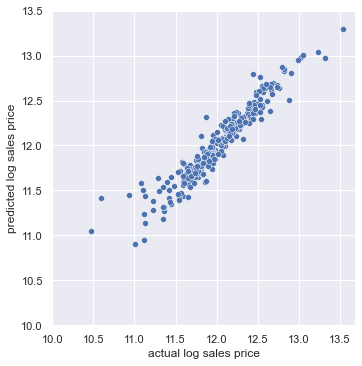

In [35]:
ticks = np.arange(10,14, 0.5)
g = sns.relplot(x=df_seg_test['log_SalePrice'], y = df_seg_test['pred_log_SalePrice'], kind='scatter')
g.set_axis_labels("actual log sales price", "predicted log sales price")
g.axes.flat[0].set_xticks(ticks)
g.axes.flat[0].set_yticks(ticks)

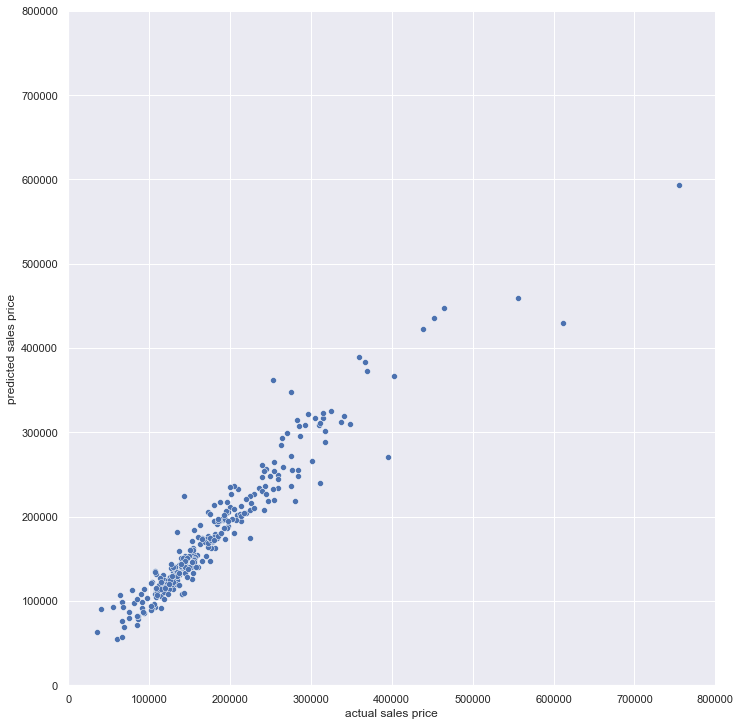

In [36]:
ticks = np.arange(0, 900000, 100000)
g = sns.relplot(x=df_seg_test['SalePrice'], y = df_seg_test['pred_SalePrice'], kind='scatter', height = 10)
g.set_axis_labels("actual sales price", "predicted sales price")
g.axes.flat[0].set_xticks(ticks)
g.axes.flat[0].set_yticks(ticks)

XGboost model summary

Training Score: -0.1229

Test Score: -0.1308

best hyperparameters:

{'colsample_bytree': 0.4,

'eta': 0.05,

'max_depth': 4,

'n_estimators': 800,

'subsample': 0.4}

# Modeling: LightGBM + Gridsearch

In [39]:
df_seg_train, df_seg_test = train_test_split(df_train_1, test_size = 0.2, random_state=42)
X_train = df_seg_train[var_cols]
y_train = df_seg_train['log_SalePrice']
X_test = df_seg_test[var_cols]
y_test = df_seg_test['log_SalePrice']

In [44]:
param_grid = [{'num_leaves': [2, 3, 5],
               'learning_rate': [0.05, 0.1, 0.15, 0.2],
               'max_depth': [2,3,4,5],
               'n_estimators': [200, 250, 300, 350, 400, 500, 600, 700, 800, 900]}]
model = lgb.LGBMRegressor()
grid_search_lgb = RandomizedSearchCV(model, param_grid, cv=5, scoring = 'neg_root_mean_squared_error')

In [45]:
grid_search_lgb.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(),
                   param_distributions=[{'learning_rate': [0.05, 0.1, 0.15,
                                                           0.2],
                                         'max_depth': [2, 3, 4, 5],
                                         'n_estimators': [200, 250, 300, 350,
                                                          400, 500, 600, 700,
                                                          800, 900],
                                         'num_leaves': [2, 3, 5]}],
                   scoring='neg_root_mean_squared_error')

In [53]:
# grid_search_lgb.best_estimator_
# LGBMRegressor(learning_rate=0.05, max_depth=4, n_estimators=900, num_leaves=5)
grid_search_lgb.best_params_
# {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 900, 'num_leaves': 5}
# grid_search_lgb.best_score_
# - 0.1253; slightly worse than the xgboost

{'num_leaves': 3, 'n_estimators': 700, 'max_depth': 5, 'learning_rate': 0.1}

In [47]:
# save the model 
models = '/Volumes/GoogleDrive/My Drive/data science/03_house_price_advanced_regression/models'
joblib.dump(grid_search_lgb, os.path.join(models, 'gs_lgb.pkl'))
# model = joblib.load(os.path.join(models, 'gs_lgb.pkl'))

['/Volumes/GoogleDrive/My Drive/data science/03_house_price_advanced_regression/models/gs_lgb.pkl']

In [48]:
# df_seg_test['pred_log_SalePrice']=grid_search_lgb.predict(df_seg_test[var_cols])
df_seg_test['pred_log_SalePrice']=grid_search_lgb.predict(df_seg_test[var_cols])
df_seg_test['pred_SalePrice'] = np.exp(df_seg_test['pred_log_SalePrice'])

/Users/ryansun/opt/anaconda3/envs/analytics37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ryansun/opt/anaconda3/envs/analytics37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [49]:
from sklearn.metrics import mean_squared_error
# Light GBM model test score:
print('Light GBM model test score: ' + str(- mean_squared_error(df_seg_test['pred_log_SalePrice'], y_test, squared=False)))

Light GBM model test score: -0.13577897989449042


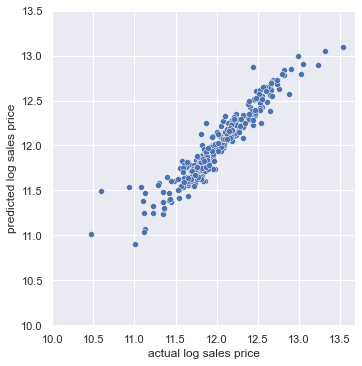

In [50]:
ticks = np.arange(10,14, 0.5)
g = sns.relplot(x=df_seg_test['log_SalePrice'], y = df_seg_test['pred_log_SalePrice'], kind='scatter')
g.set_axis_labels("actual log sales price", "predicted log sales price")
g.axes.flat[0].set_xticks(ticks)
g.axes.flat[0].set_yticks(ticks)

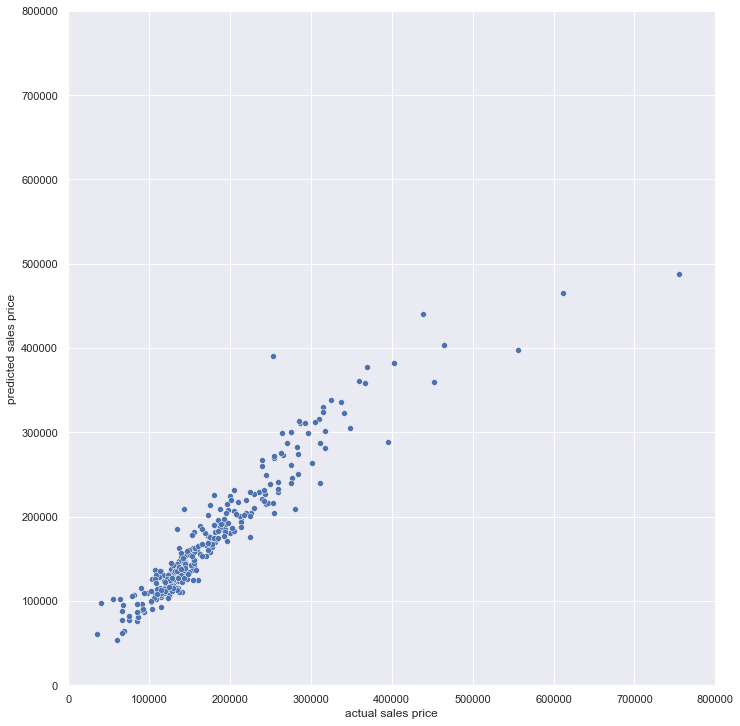

In [51]:
ticks = np.arange(0, 900000, 100000)
g = sns.relplot(x=df_seg_test['SalePrice'], y = df_seg_test['pred_SalePrice'], kind='scatter', height = 10)
g.set_axis_labels("actual sales price", "predicted sales price")
g.axes.flat[0].set_xticks(ticks)
g.axes.flat[0].set_yticks(ticks)

Light GBM with grid search summary:

Training score: - 0.1263

Test score: -0.1358

best hyperparameters: {'num_leaves': 3, 'n_estimators': 700, 'max_depth': 5, 'learning_rate': 0.1}




# LightGBM with Randomized Search

In [54]:
num_leaves = np.arange(2,8,1)
learning_rate = np.arange(0.05,0.4,0.05)
max_depth = np.arange(2,6,1)
n_estimators = np.arange(200,900,100)

In [62]:
# try randomized search
param_grid = [{'num_leaves': [2, 3, 5],
               'learning_rate': [0.05, 0.1, 0.15, 0.2],
               'max_depth': [2,3,4,5],
               'n_estimators': [200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 900]}]
model = lgb.LGBMRegressor()
random_search_lgb = RandomizedSearchCV(model, param_grid, cv=5, scoring = 'neg_root_mean_squared_error', n_iter=100)

In [63]:
random_search_lgb.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(), n_iter=100,
                   param_distributions=[{'learning_rate': [0.05, 0.1, 0.15,
                                                           0.2],
                                         'max_depth': [2, 3, 4, 5],
                                         'n_estimators': [200, 250, 300, 350,
                                                          400, 450, 500, 550,
                                                          600, 650, 700, 750,
                                                          800, 900],
                                         'num_leaves': [2, 3, 5]}],
                   scoring='neg_root_mean_squared_error')

In [68]:
# random_search_lgb.best_params_
# random_search_lgb.best_score_
random_search_lgb.best_params_
# random_search_lgb.best_score_
# -0.12544746272272192

{'num_leaves': 3, 'n_estimators': 800, 'max_depth': 2, 'learning_rate': 0.1}

In [67]:
df_seg_test['pred_log_SalePrice']=random_search_lgb.predict(df_seg_test[var_cols])
df_seg_test['pred_SalePrice'] = np.exp(df_seg_test['pred_log_SalePrice'])
print('Light GBM model with randomized search test score: ' + str(- mean_squared_error(df_seg_test['pred_log_SalePrice'], y_test, squared=False)))

Light GBM model with randomized search test score: -0.13573142755831205


Light GBM with randomized search summary:

Training score: - 0.1260

Test score: -0.1357

best hyperparameters: {'num_leaves': 3, 'n_estimators': 800, 'max_depth': 2, 'learning_rate': 0.1}

# Ridge Regression

In [69]:
# go from here
scaler = StandardScaler()
df_data_2 = df_data_1.copy()
df_data_2[num_cols] = scaler.fit_transform(df_data_2[num_cols])

In [70]:
df_train_2 = df_data_2[df_data_2['SalePrice'].notnull()].copy()
df_test_2 = df_data_2[df_data_2['SalePrice'].isnull()].copy()

In [71]:
df_seg_train, df_seg_test = train_test_split(df_train_2, test_size = 0.2, random_state=42)
X_train = df_seg_train[var_cols]
y_train = df_seg_train['log_SalePrice']
X_test = df_seg_test[var_cols]
y_test = df_seg_test['log_SalePrice']

In [72]:
def neg_rmse(model):
    scores = cross_val_score(model, X_train, y_train, scoring="neg_root_mean_squared_error", cv = 5)
    return scores

In [73]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [neg_rmse(Ridge(alpha = alpha)).mean() for alpha in alphas]

In [74]:
np.max(cv_ridge)

-0.14260533306853054

In [76]:
cv_ridge

0.05    -0.165727
0.10    -0.162695
0.30    -0.156186
1.00    -0.149685
3.00    -0.145957
5.00    -0.144642
10.00   -0.143230
15.00   -0.142717
30.00   -0.142605
50.00   -0.143192
75.00   -0.144016
dtype: float64

Text(0, 0.5, 'rmse')

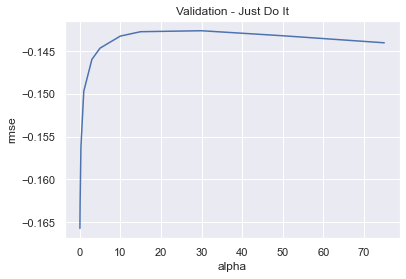

In [75]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
# alpha = 30

In [77]:
model = Ridge(alpha = 30)
model.fit(X_train, y_train)

Ridge(alpha=30)

In [78]:
df_seg_test['pred_log_SalePrice']=model.predict(df_seg_test[var_cols])
print('Ridge Regression test score: ' + str(- mean_squared_error(df_seg_test['pred_log_SalePrice'], y_test, squared=False)))

Ridge Regression test score: -0.13806202094050993


/Users/ryansun/opt/anaconda3/envs/analytics37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Ridge regression summary:

training score: -0.1426

test score: -0.1381

In [ ]:
# alternative method for running ridge regression: 
# model = RidgeCV(alphas=[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75], 
#                 scoring = 'neg_root_mean_squared_error',cv = 5).fit(X_train, y_train)

# a stack model

In [35]:
df_seg_train, df_seg_test = train_test_split(df_train_1, test_size = 0.2, random_state=42)
X_train = df_seg_train[var_cols]
y_train = df_seg_train['log_SalePrice']

X_test = df_seg_test[var_cols]
y_test = df_seg_test['log_SalePrice']

# best XGboost
# {'colsample_bytree': 0.4,
#  'eta': 0.05,
#  'max_depth': 4,
#  'n_estimators': 800,
#  'subsample': 0.4}

# best lightGBM
# {'num_leaves': 3, 'n_estimators': 800, 'max_depth': 2, 'learning_rate': 0.1}

# setting the scoring function here does not matter, because it will not change how the model is built
xgb_model = xgb.XGBRegressor(colsample_bytree=0.4, eta=0.05, n_estimators = 800, max_depth=4, subsample=0.4)
lgb_model = lgb.LGBMRegressor(learning_rate=0.1, max_depth=2, n_estimators=800, num_leaves = 3)
final_estimator = RidgeCV()

In [36]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, eta=0.05, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.0500000007, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=800, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.4,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [37]:
lgb_model.fit(X_train, y_train)

LGBMRegressor(max_depth=2, n_estimators=800, num_leaves=3)

In [38]:
estimators = [('xgb', xgb_model), ('lgb', lgb_model)]

In [39]:
stack_model = StackingRegressor(estimators=estimators, cv = 3)

In [40]:
stack_model.fit(X_train, y_train)
# lgb_model.fit(X_train, y_train)

StackingRegressor(cv=3,
                  estimators=[('xgb',
                               XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=0.4, eta=0.05,
                                            gamma=0, gpu_id=-1,
                                            importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.0500000007,
                                            max_delta_step=0, max_depth=4,
                                            min_child_weight=1, missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=800, n_jobs=12,
                                            num_parallel_tree=1, random_state=0,
  

In [41]:
y_train_stack_pred = stack_model.predict(X_train)
y_test_stack_pred = stack_model.predict(X_test)

y_test_xgb_pred = xgb_model.predict(X_test)
y_test_lgb_pred = lgb_model.predict(X_test)

In [42]:
from sklearn.metrics import mean_squared_error

In [43]:
# after stacking, the mean square error did not become much better
print('stacking model training score: ' +  str(- mean_squared_error(y_train_stack_pred, y_train, squared=False)))
print('stacking model test score: ' +  str(- mean_squared_error(y_test_stack_pred, y_test, squared=False)))
print('xgb model test score: ' +  str(- mean_squared_error(y_test_xgb_pred, y_test, squared=False)))
print('lgb model test score: ' +  str(- mean_squared_error(y_test_lgb_pred, y_test, squared=False)))

stacking model training score: -0.04323678799478017
stacking model test score: -0.129858789869183
xgb model test score: -0.13082875522401916
lgb model test score: -0.13573142755831205


# final model and prediction

In [44]:
# include all data for final training
X_train = df_train_1[var_cols]
y_train = df_train_1['log_SalePrice']

In [45]:
df_train_1

Id  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageYrBlt  GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  SalePrice  log_SalePrice  MSSubClass_120  MSSubClass_150  MSSubClass_160  MSSubClass_180  MSSubClass_190  MSSubClass_20  MSSubClass_30  MSSubClass_40  MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  Street_Grvl  Street_Pave  Alley_Grvl  Alley_No Alley Access  Alley_Pave  LotShape_IR1  LotShape_IR2  LotShape_IR3  LotShape_Reg  LandContour_Bnk  LandContour_HLS  LandContour_Low  LandContour_Lvl  Utilities_AllPub  \
0        1         65.0     8450            7            5       2003          2003       196.0       706.0         0.0      150.0        856.0       856       854             0       1710           1.0           0.0         2         1             3             1             8           0       2003.0         2.0       548.0           0           61              0          0            0         0        0       2    2008   208500.0      12.247694               0               0               0               0               0              0              0              0              0              0              1              0              0              0              0              0                 0            0            0            1            0            0            1           0                      1           0             0             0             0             1                0                0                0                1                 1   
1        2         80.0     9600            6            8       1976          1976         0.0       978.0         0.0      284.0       1262.0      1262         0             0       1262           0.0           1.0         2         0             3             1             6           1       1976.0         2.0       460.0         298            0              0          0            0         0        0       5    2007   181500.0      12.109011               0               0               0               0               0              1              0              0              0              0              0              0              0              0              0              0                 0            0            0            1            0            0            1           0                      1           0             0             0             0             1                0                0                0                1                 1   
2        3         68.0    11250            7            5       2001          2002       162.0       486.0         0.0      434.0        920.0       920       866             0       1786           1.0           0.0         2         1             3             1             6           1       2001.0         2.0       608.0           0           42              0          0            0         0        0       9    2008   223500.0      12.317167               0               0               0               0               0              0              0              0              0              0              1              0              0              0              0              0                 0            0            0            1            0            0            1           0                      1           0             1             0             0             0                0                0                0                1                 1   
3        4         60.0     9550            7            5      

In [46]:
# Xgboost
# {'colsample_bytree': 0.4,
#  'eta': 0.05,
#  'max_depth': 4,
#  'n_estimators': 800,
#  'subsample': 0.4}

# Light GBM
# {'num_leaves': 3, 'n_estimators': 800, 'max_depth': 2, 'learning_rate': 0.1}

xgb_model = xgb.XGBRegressor(colsample_bytree=0.4, eta=0.05, n_estimators = 800, max_depth=4, subsample=0.4)
lgb_model = lgb.LGBMRegressor(learning_rate=0.1, max_depth=2, n_estimators=800, num_leaves = 3)
final_estimator = RidgeCV()

In [47]:
estimators = [('xgb', xgb_model), ('lgb', lgb_model)]
stack_model = StackingRegressor(estimators=estimators, cv = 3)

In [48]:
stack_model.fit(X_train, y_train)

StackingRegressor(cv=3,
                  estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.4, eta=0.05,
                                            gamma=None, gpu_id=None,
                                            importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=4,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=800, n_jobs=None,
                                            num_parallel_tree=None,
     

In [49]:
y_train_stack_pred = stack_model.predict(X_train)

In [50]:
print('stacking model score: ' +  str(- mean_squared_error(y_train, y_train_stack_pred, squared=False)))

stacking model score: -0.049233447025679423


Prediction

In [51]:
df_test_1['pred_log_SalePrice']=stack_model.predict(df_test_1[var_cols])
df_test_1['pred_SalePrice'] = np.exp(df_test_1['pred_log_SalePrice'])

In [54]:
df_test_1.head()

Id  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageYrBlt  GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  SalePrice  log_SalePrice  MSSubClass_120  MSSubClass_150  MSSubClass_160  MSSubClass_180  MSSubClass_190  MSSubClass_20  MSSubClass_30  MSSubClass_40  MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  Street_Grvl  Street_Pave  Alley_Grvl  Alley_No Alley Access  Alley_Pave  LotShape_IR1  LotShape_IR2  LotShape_IR3  LotShape_Reg  LandContour_Bnk  LandContour_HLS  LandContour_Low  LandContour_Lvl  Utilities_AllPub  \
1460  1461         80.0    11622            5            6       1961          1961         0.0       468.0       144.0      270.0        882.0       896         0             0        896           0.0           0.0         1         0             2             1             5           0       1961.0         1.0       730.0         140            0              0          0          120         0        0       6    2010        NaN            NaN               0               0               0               0               0              1              0              0              0              0              0              0              0              0              0              0                 0            0            1            0            0            0            1           0                      1           0             0             0             0             1                0                0                0                1                 1   
1461  1462         81.0    14267            6            6       1958          1958       108.0       923.0         0.0      406.0       1329.0      1329         0             0       1329           0.0           0.0         1         1             3             1             6           0       1958.0         1.0       312.0         393           36              0          0            0         0    12500       6    2010        NaN            NaN               0               0               0               0               0              1              0              0              0              0              0              0              0              0              0              0                 0            0            0            1            0            0            1           0                      1           0             1             0             0             0                0                0                0                1                 1   
1462  1463         74.0    13830            5            5       1997          1998         0.0       791.0         0.0      137.0        928.0       928       701             0       1629           0.0           0.0         2         1             3             1             6           1       1997.0         2.0       482.0         212           34              0          0            0         0        0       3    2010        NaN            NaN               0               0               0               0               0              0              0              0              0              0              1              0              0              0              0              0                 0            0            0            1            0            0            1           0                      1           0             1             0             0             0                0                0                0                1                 1   
1463  1464         78.0     9978            6            6      

In [55]:
df_submission = df_test_1[['Id', 'pred_SalePrice']].copy()
df_submission.rename(columns={'pred_SalePrice': 'SalePrice'}, inplace=True)

In [56]:
df_submission.to_csv(os.path.join(data, 'submission.csv'), index=False)